# Imports

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import matplotlib.dates as mdates
import statistics
import re
import sharedVariables
from sharedVariables import *

In [343]:
# Datasets
dataset_sources = {
    'advanced': 'data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9',
    'baseline': 'data/data-baseline-with-latency-9/20210930-03-experiment-baseline-with-latency-9',
    'syncmesh': 'data/data-syncmesh-with-latency-9/20210930-04-experiment-syncmesh-with-latency-9'
}
# dataset_sources = {
#     'advanced': 'data/data-advanced-mongo-with-latency-6/20210929-22-experiment-advanced-mongo-with-latency-6',
#     'baseline': 'data/data-baseline-with-latency-6/20210929-11-experiment-baseline-with-latency-6',
#     'syncmesh': 'data/data-syncmesh-with-latency-6/20210929-11-experiment-syncmesh-with-latency-6'
# }
# dataset_sources = {
#     'advanced': 'data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3',
#     'baseline': 'data/data-baseline-with-latency-3/20210929-21-experiment-baseline-with-latency-3',
#     'syncmesh': 'data/data-syncmesh-with-latency-3/20210929-21-experiment-syncmesh-with-latency-3'
# }
try: 
    print(ci)
except Exception:  
    ci = False

if ci == "true": 
    dataset_sources = {}
    print("Running CI Data detection")
    for folder in os.listdir("data"):
        if folder.startswith("data"):
            dashes = [m.start() for m in re.finditer('-', folder)]
            dataset_sources[folder[5:dashes[1]]] = "data/" + folder + "/" + os.listdir("data/" + folder)[0]
dataset_sources

False


{'advanced': 'data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9',
 'baseline': 'data/data-baseline-with-latency-9/20210930-03-experiment-baseline-with-latency-9',
 'syncmesh': 'data/data-syncmesh-with-latency-9/20210930-04-experiment-syncmesh-with-latency-9'}

In [344]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

def to_MB(size, unit=True):
    size /= 1000*1000
    return "{0:.2f}".format(size)

In [345]:
ip_seperator

'92.60.39.199'

In [346]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[(df["tcp.dstport"] == 443)] #  | (df["tcp.srcport"] == 443)
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    df = df[(df["tcp.dstport"] != 22) & (df["tcp.srcport"] != 22)]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith("10"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)
            # print(len(currentdf))

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True,subset=['ip.src', 'ip.dst'])
            # currentdf.to_csv(filename + ".csv")

            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    # df_base.sort_index().to_csv("test.csv")
    # print(df_base)
    df_base = filterDataForLocalTraffic(df_base)
    node_list = list(dict.fromkeys(df_base["ip.src"].unique().tolist() + df_base["ip.dst"].unique().tolist()))
    node_list = [node for node in node_list if node not in ["10.0.0.2", "10.0.0.3", "10.0.0.4", "10.0.0.255"]]
    print(node_list)
    return (df_base.sort_index(), timings, len(node_list))

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])

    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
datasets["advanced"][1]

c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\10.0.0.2.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\10.0.0.3.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\10.2.0.12.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\10.3.0.13.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\10.4.0.14.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\d

array(['2021-09-30T05:23:50.610327000', '2021-09-30T05:27:22.394546000',
       '2021-09-30T05:31:27.654408000', '2021-09-30T05:36:02.990863000',
       '2021-09-30T05:41:40.878929000', '2021-09-30T05:45:03.994455000',
       '2021-09-30T05:48:27.146498000', '2021-09-30T05:51:50.666404000',
       '2021-09-30T05:55:14.226453000'], dtype='datetime64[ns]')

In [347]:
df = datasets["syncmesh"][0]
# df[(df['ip.src']=='10.1.0.11') & (df['ip.dst']=='10.2.0.12')]
# df[(df['ip.src']=='10.1.0.11')]
df

tcp.analysis.initial_rtt       ip.id     ip.src  \
frame.time_epoch                                                              
2021-09-30 03:34:47.404643                       NaN  0x00008ded   10.0.0.2   
2021-09-30 03:34:47.419479                       NaN  0x00008ded   10.0.0.2   
2021-09-30 03:34:47.419532                       NaN  0x00000000  10.1.0.11   
2021-09-30 03:34:47.434231                       NaN  0x00000000  10.1.0.11   
2021-09-30 03:34:47.434264                  0.029621  0x00008dee   10.0.0.2   
...                                              ...         ...        ...   
2021-09-30 04:07:23.645719                       NaN  0x00007fad  10.9.0.19   
2021-09-30 04:07:23.645869                  0.066857  0x0000d46a  10.1.0.11   
2021-09-30 04:07:23.679256                  0.066611  0x0000d46a  10.1.0.11   
2021-09-30 04:07:23.679293                  0.066611  0x00007fae  10.9.0.19   
2021-09-30 04:07:23.712113                  0.066857  0x00007fae  10.9.0.19   

                               ip.dst  ip.len  tcp.srcport  tcp.dstport  
frame.time_epoch                                                         
2021-09-30 03:34:47.404643  10.1.0.11    60.0      48156.0       8080.0  
2021-09-30 03:34:47.419479  10.1.0.11    60.0      48156.0       8080.0  
2021-09-30 03:34:47.419532   10.0.0.2    60.0       8080.0      48156.0  
2021-09-30 03:34:47.434231   10.0.0.2    60.0       8080.0      48156.0  
2021-09-30 03:34:47.434264  10.1.0.11    52.0      48156.0       8080.0  
...                               ...     ...          ...          ...  
2021-09-30 04:07:23.645719  10.1.0.11    52.0       8080.0      38050.0  
2021-09-30 04:07:23.645869  10.9.0.19    52.0      38050.0       8080.0  
2021-09-30 04:07:23.679256  10.9.0.19    52.0      38050.0       8080.0  
2021-09-30 04:07:23.679293  10.1.0.11    52.0       8080.0      38050.0  
2021-09-30 04:07:23.712113  10.1.0.11    52.0       8080.0      38050.0  

[76754 rows x 7 columns]

In [348]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))
    # print(nodes)
    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # print(df[df['ip.src']==combination[0] & df['ip.dst']==combination[1]])
        # Use both src_ip and dest_ip as they are not request related
        key = "between " + combination[0] + " and " + combination[1]
        betweenNodesDataset[key] = df[((df['ip.src']==str(combination[0])) & (df['ip.dst']==str(combination[1]))) | ((df['ip.src']==str(combination[1])) & (df['ip.dst']==str(combination[0])))]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

# setname = "syncmesh"
# for key in node_datasets[setname]:
#     print(key, ":", len(node_datasets[setname][key]))
    # print(node_datasets[setname][key])
    

In [349]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    print(key)
    print(datasets[key][1])
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "syncmesh"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


advanced
['2021-09-30T05:23:50.610327000' '2021-09-30T05:27:22.394546000'
 '2021-09-30T05:31:27.654408000' '2021-09-30T05:36:02.990863000'
 '2021-09-30T05:41:40.878929000' '2021-09-30T05:45:03.994455000'
 '2021-09-30T05:48:27.146498000' '2021-09-30T05:51:50.666404000'
 '2021-09-30T05:55:14.226453000']
baseline
['2021-09-30T01:55:01.960870000' '2021-09-30T01:58:52.292705000'
 '2021-09-30T02:03:45.272522000' '2021-09-30T02:09:42.044462000'
 '2021-09-30T02:18:05.676446000' '2021-09-30T02:21:50.928791000'
 '2021-09-30T02:26:06.816309000' '2021-09-30T02:30:48.048485000'
 '2021-09-30T02:36:29.928731000']
syncmesh
['2021-09-30T03:33:46.648583000' '2021-09-30T03:37:27.320245000'
 '2021-09-30T03:42:08.400047000' '2021-09-30T03:47:29.192840000'
 '2021-09-30T03:53:52.020462000' '2021-09-30T03:57:28.836747000'
 '2021-09-30T04:01:06.131919000' '2021-09-30T04:04:44.348004000'
 '2021-09-30T04:08:24.176003000']
collect1 : 45
collect7 : 45
collect14 : 45
collect30 : 45
aggregate1 : 45
aggregate7 : 45
a

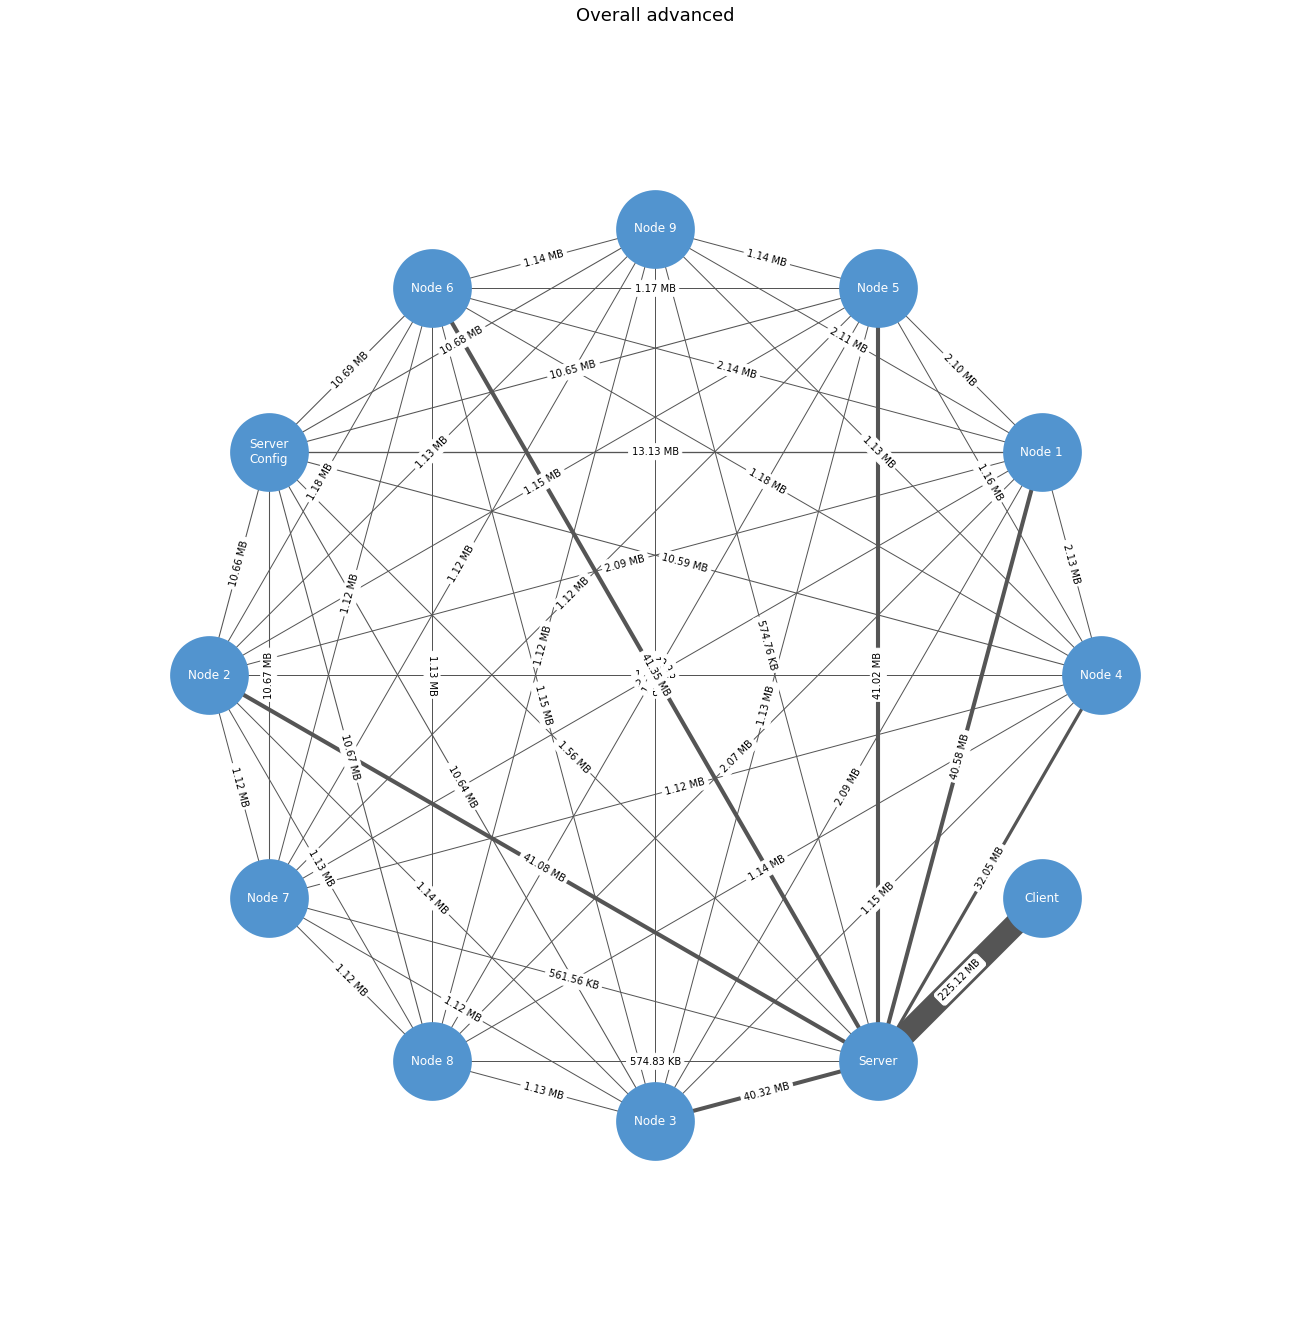

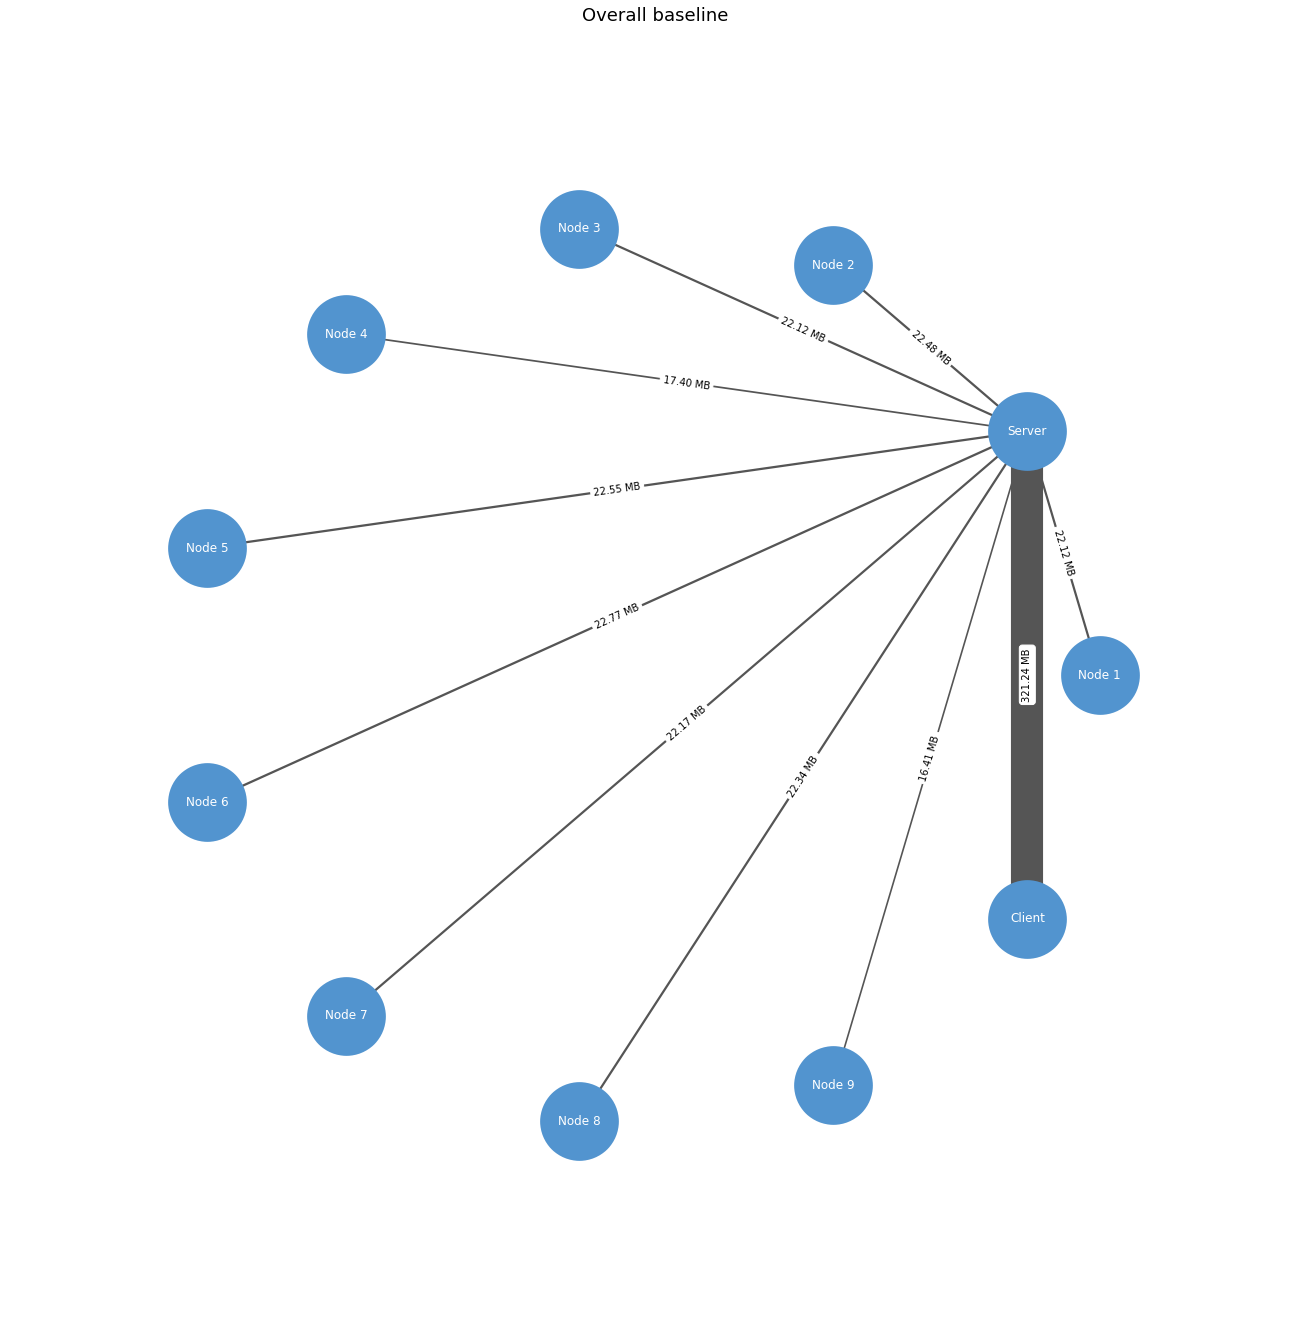

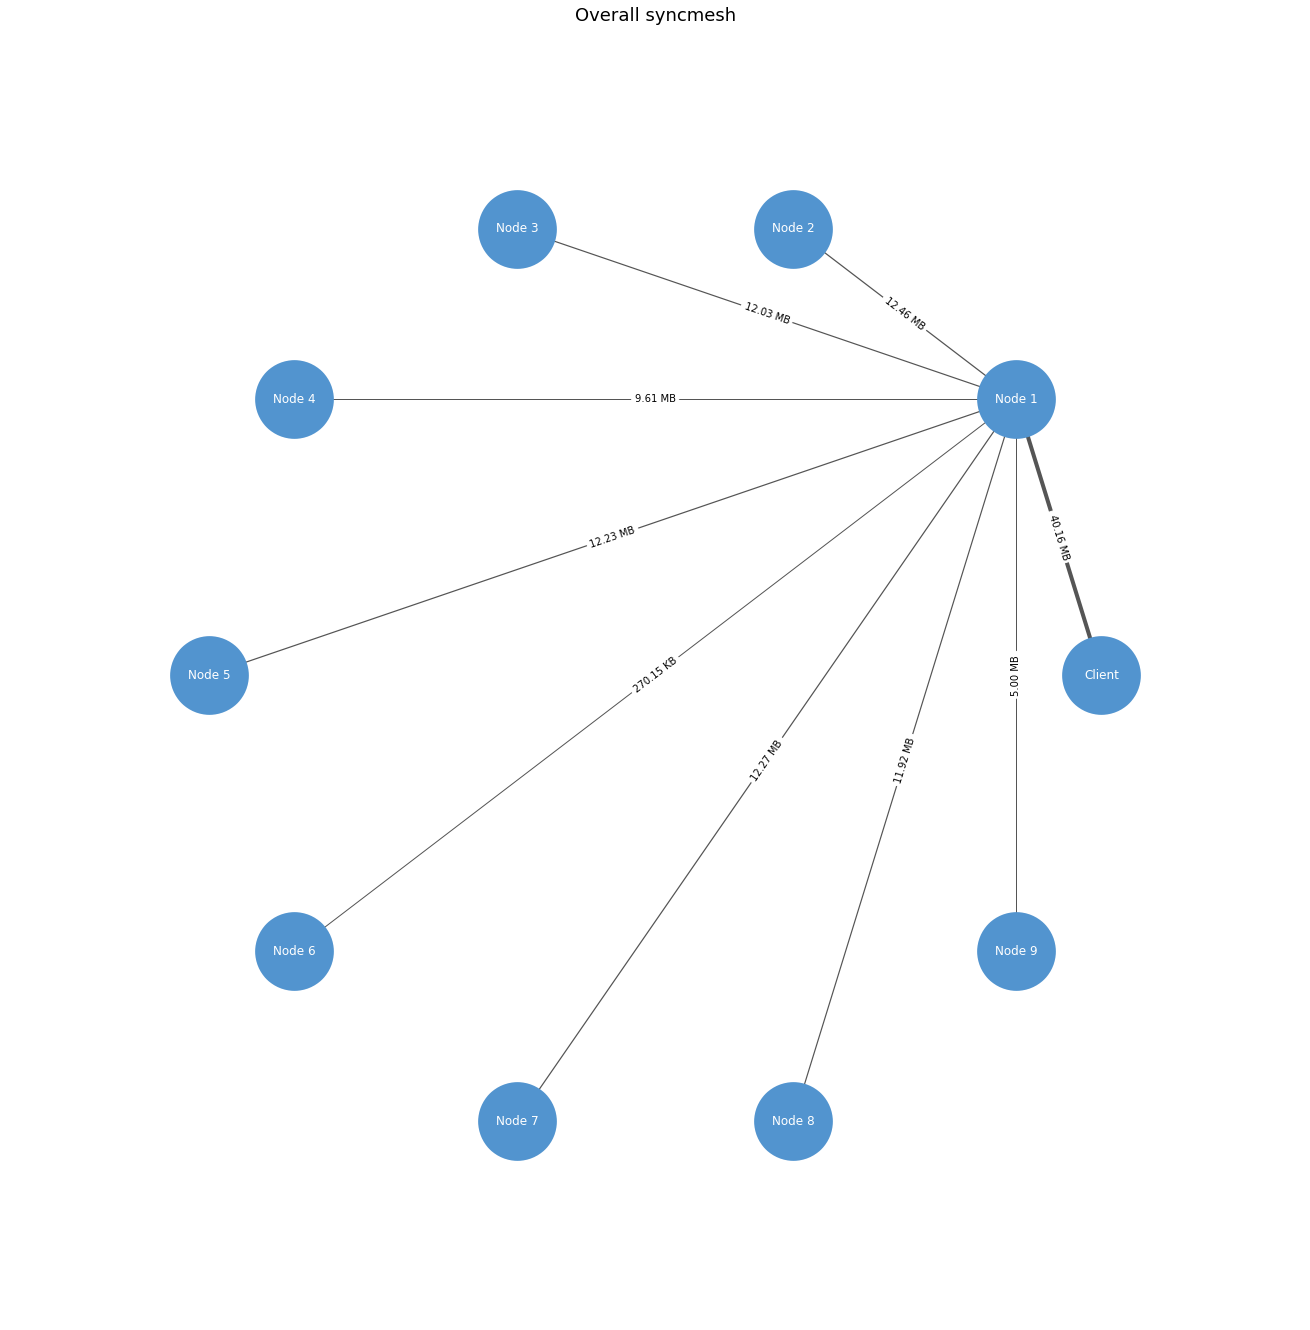

In [350]:
def get_node_name(ip):
    if(ip == "10.0.0.2"):
        return "Client"
    elif(ip == "10.0.0.3"):
        return "Server"
    elif(ip == "10.0.0.4"):
        return "Server\nConfig"
    elif(ip == "10.0.0.255"):
        return "ORCHESTRATOR"
    elif(ip.startswith("10.")):
        return "Node " + ip.split(".")[1]
    return ip

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        if len(subset["ip.dst"]) > 0:

            # if subset_key == "advanced":
                # print(node_dataset_key) 
                #print(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0]) 
                #print(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]))
            G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='#555555', weight=np.clip(subset["ip.len"].sum()/10000000 , 1, 1000), label=to_human_readable(subset["ip.len"].sum()))
            #  + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms"

    pos = nx.circular_layout(G)
    
    size=datasets[subset_key][2]/3 * 6
    plt.figure(index+1,figsize=(size,size))
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="#5294CF", font_color="w", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.savefig("out/network_"+subset_key+".png")
    

plt.show()

In [351]:
# node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
# node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/1851211818.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(int(str(index)+str(e_index)),figsize=(size,size))


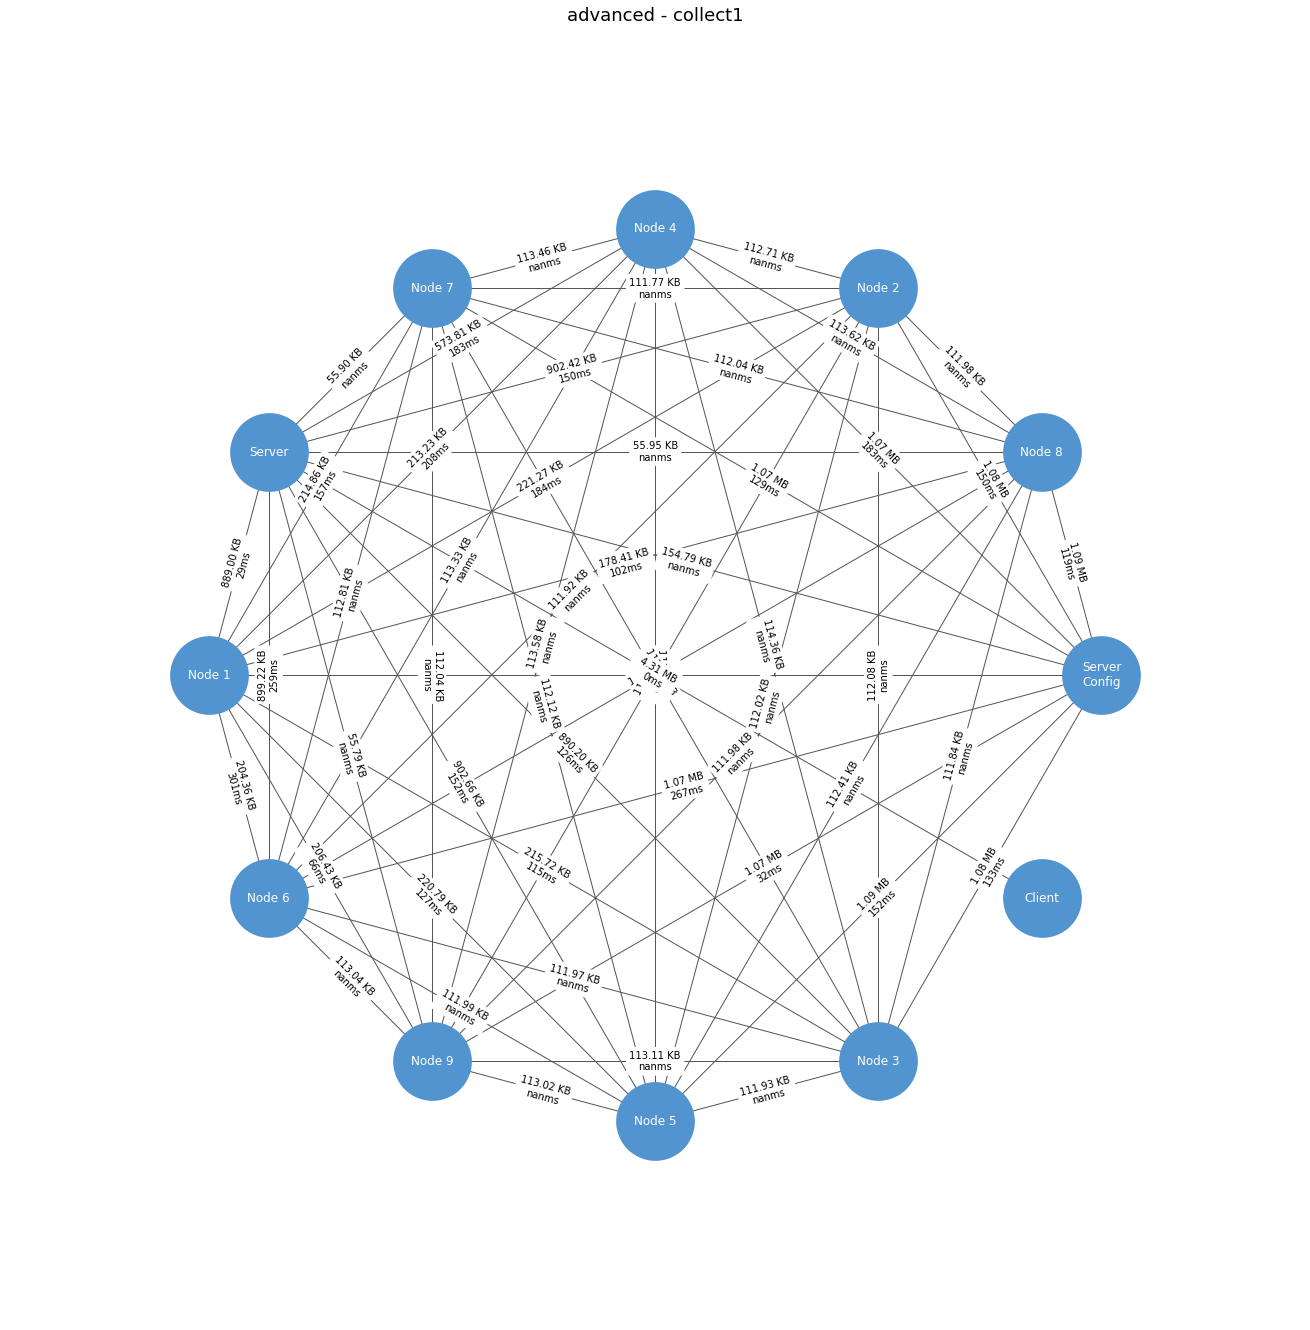

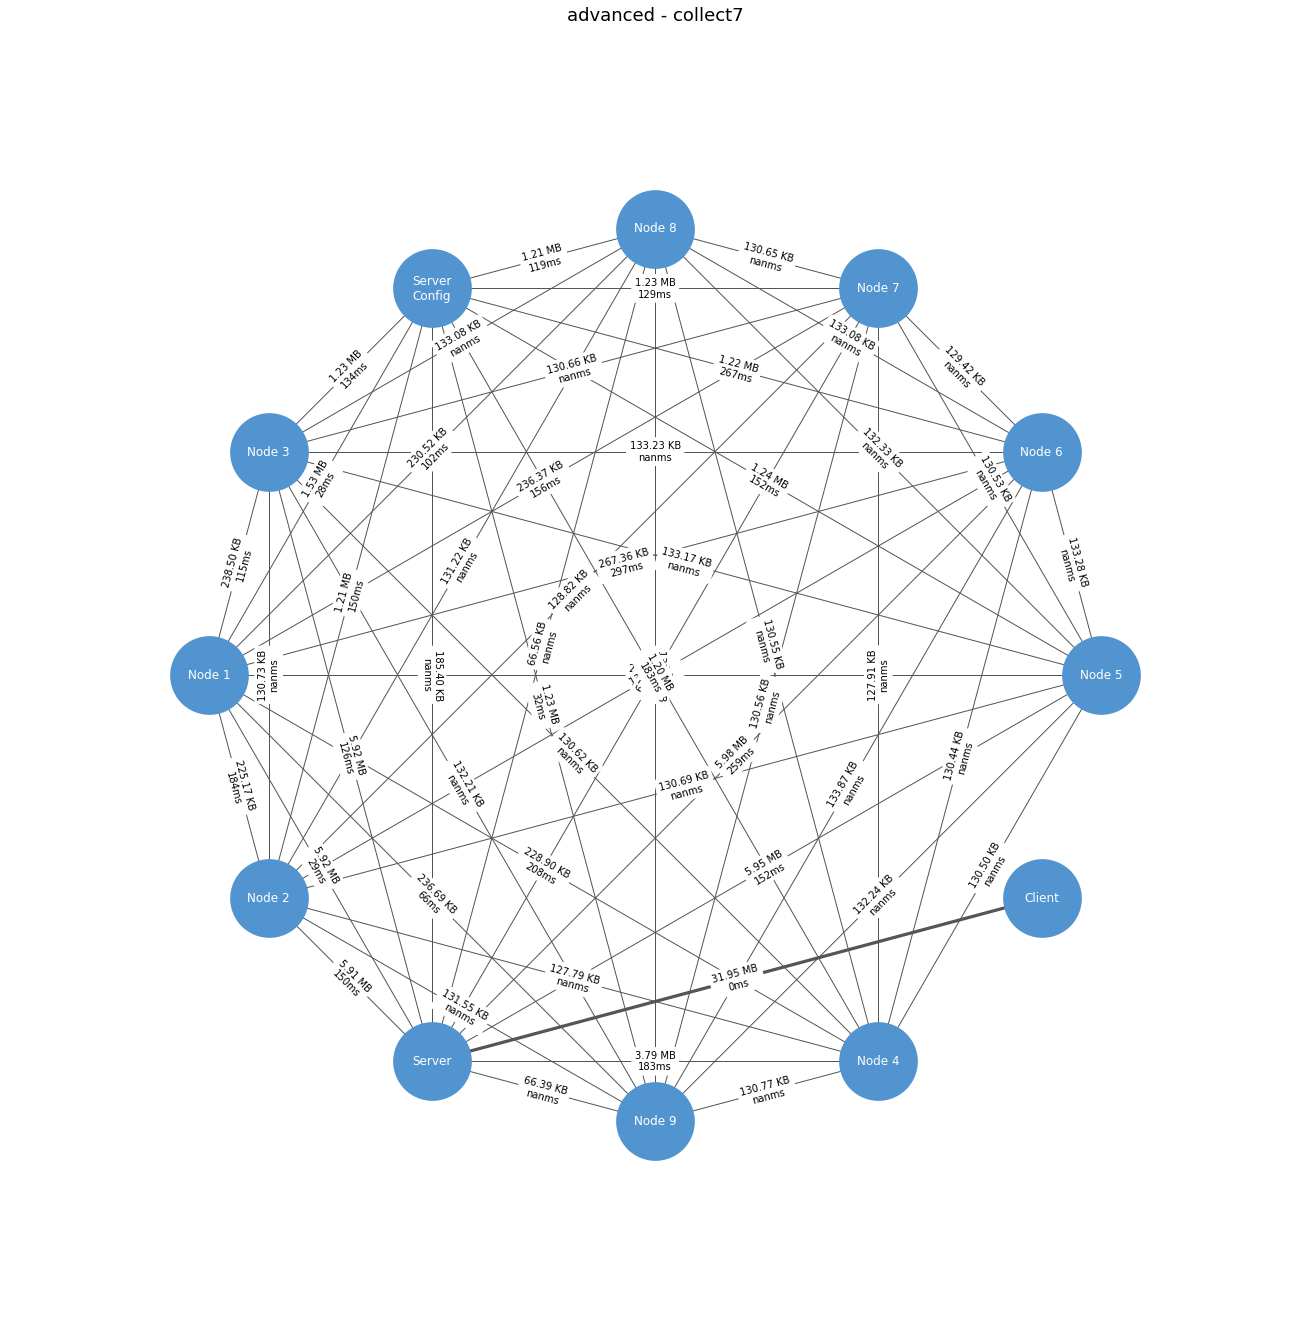

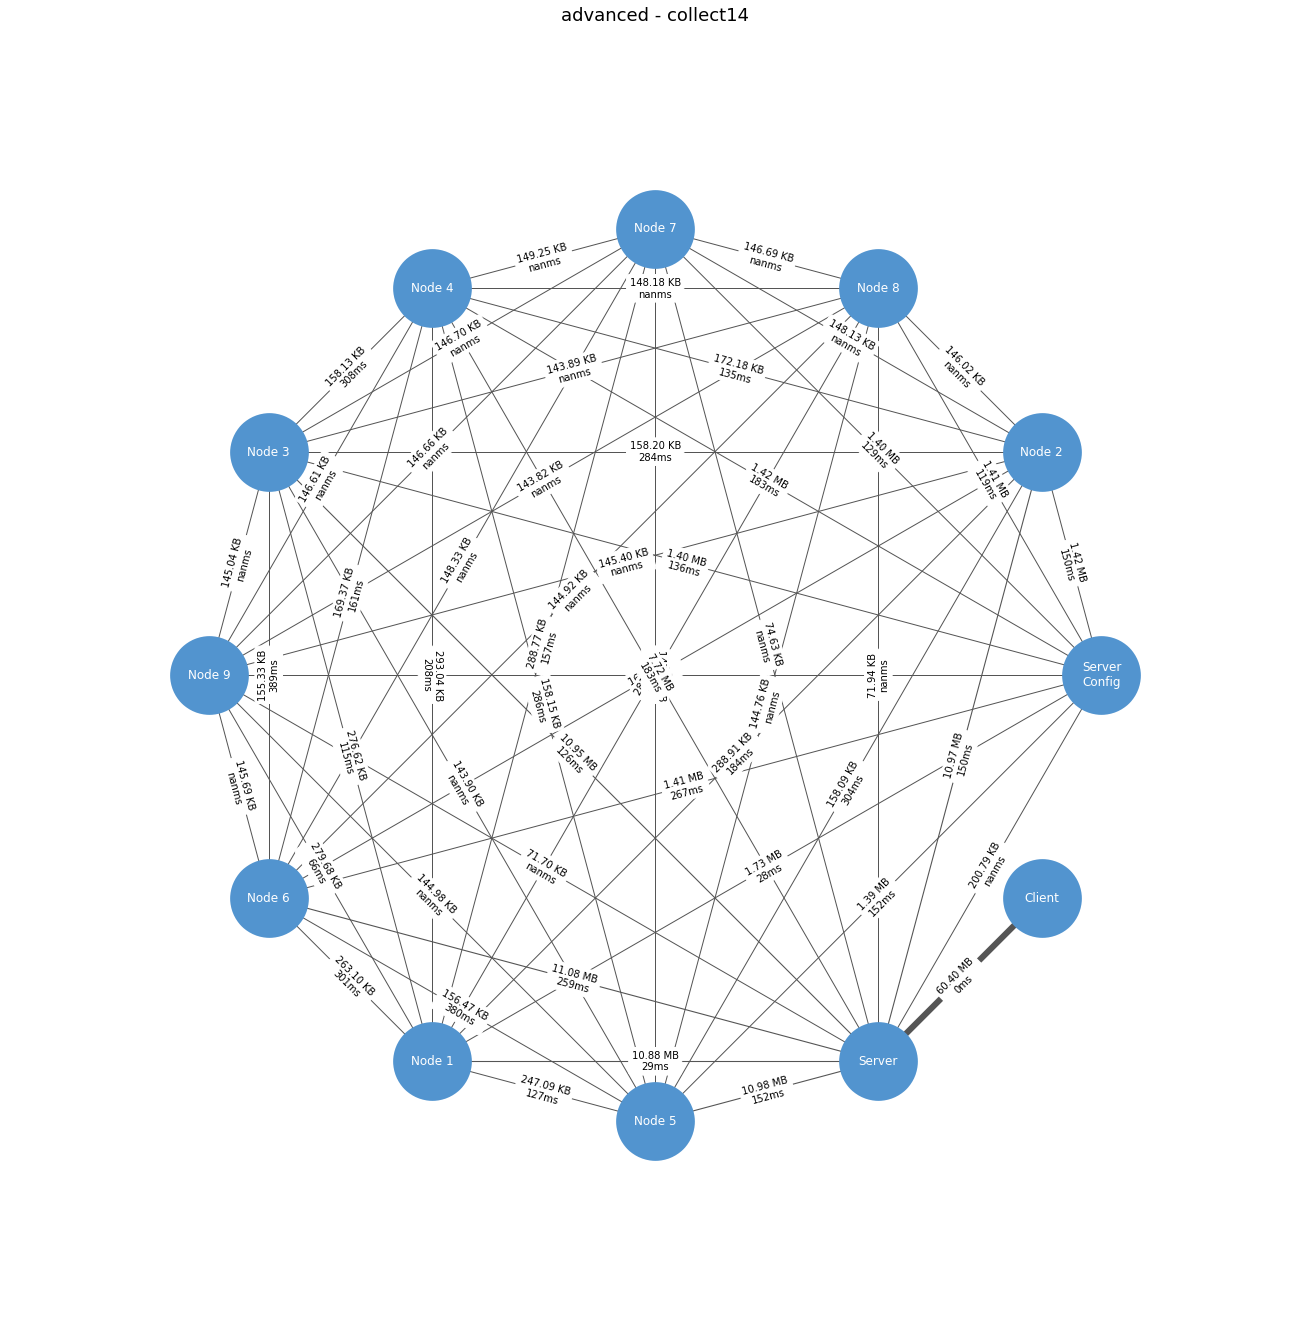

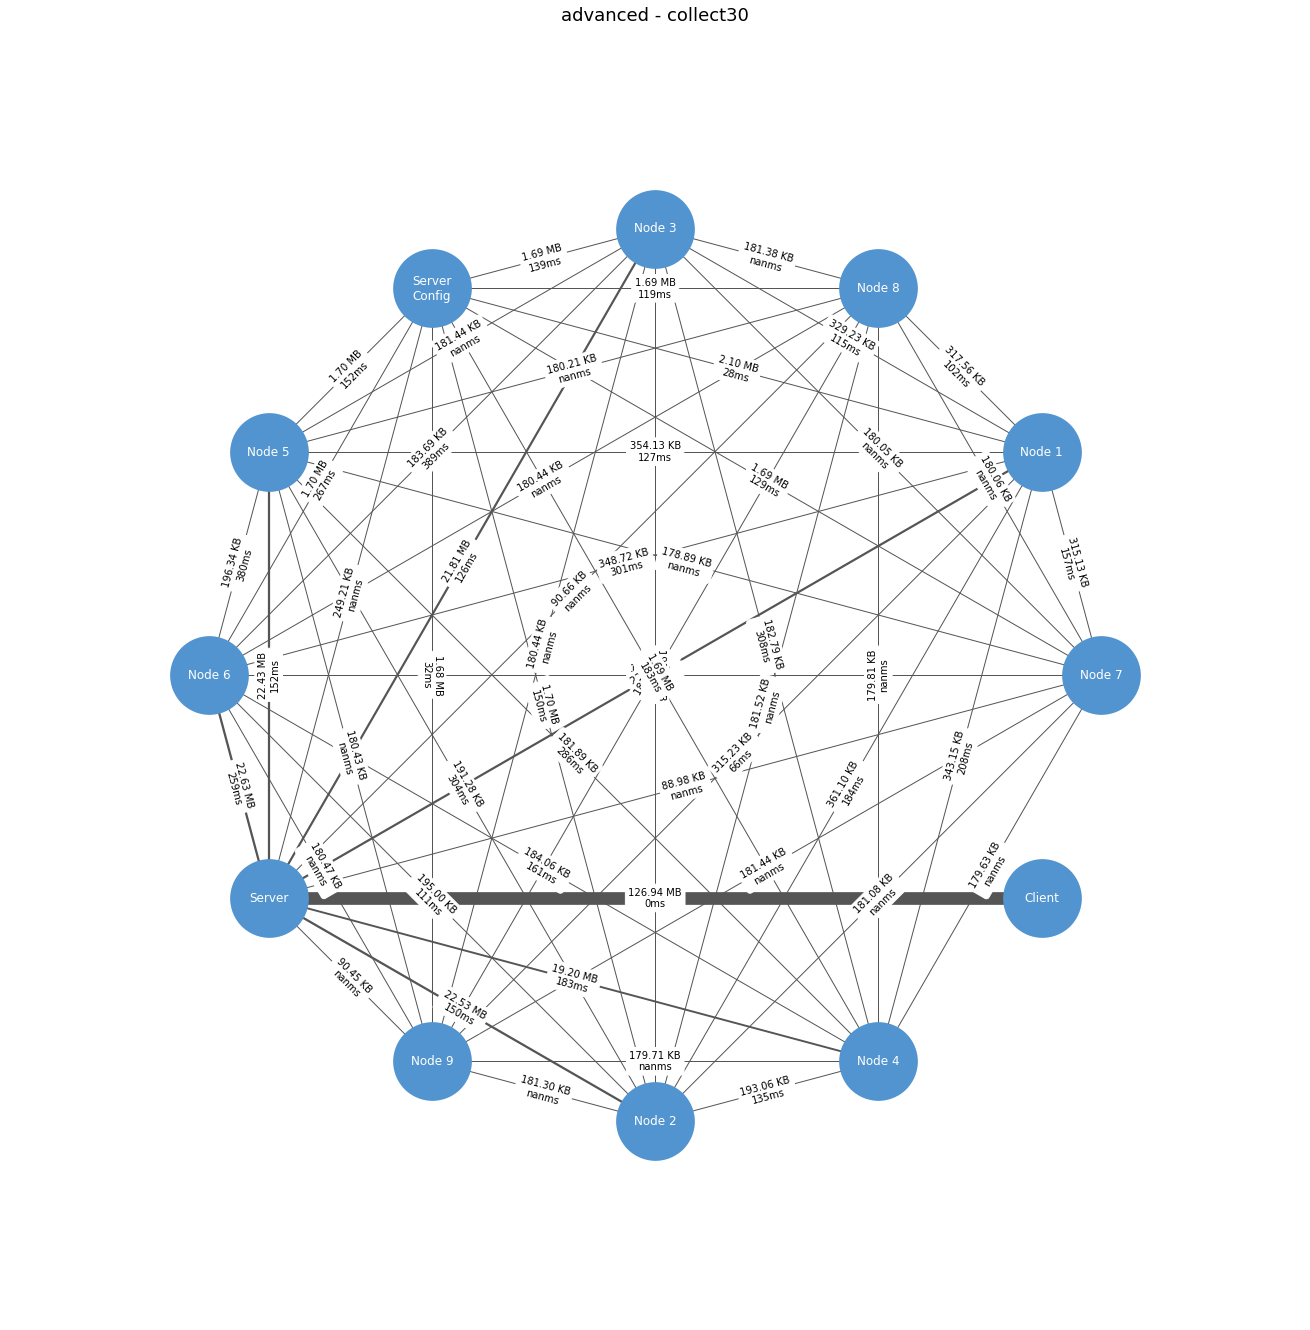

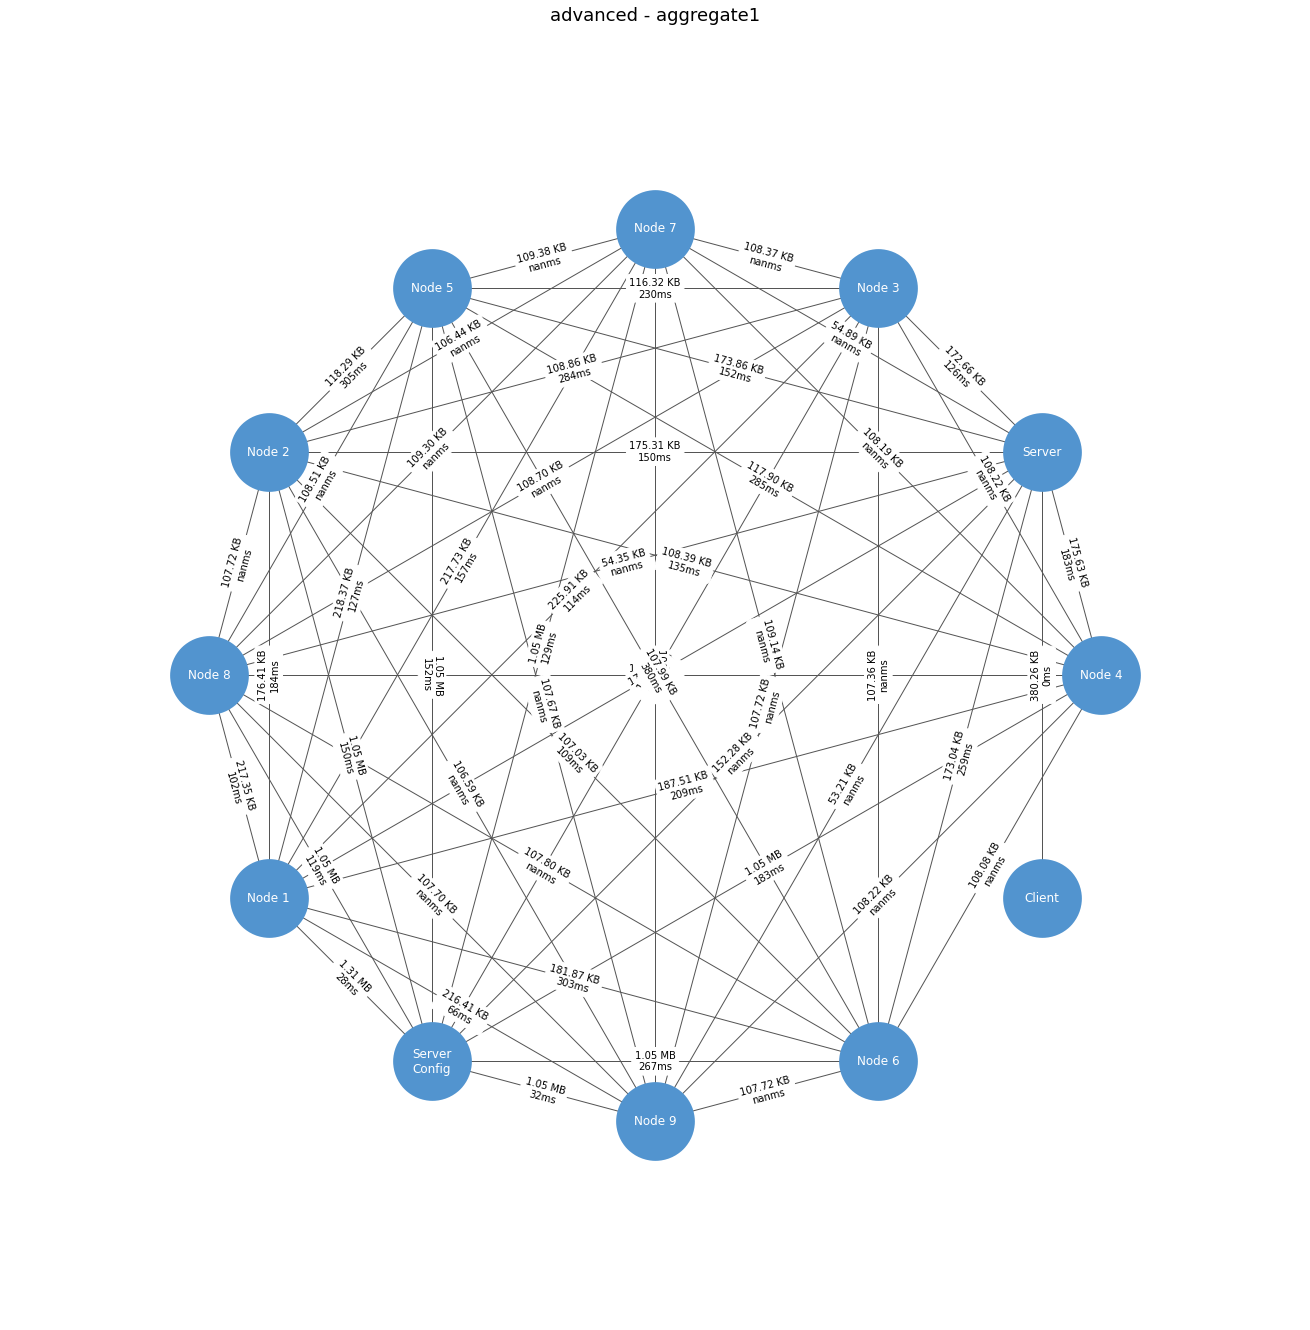

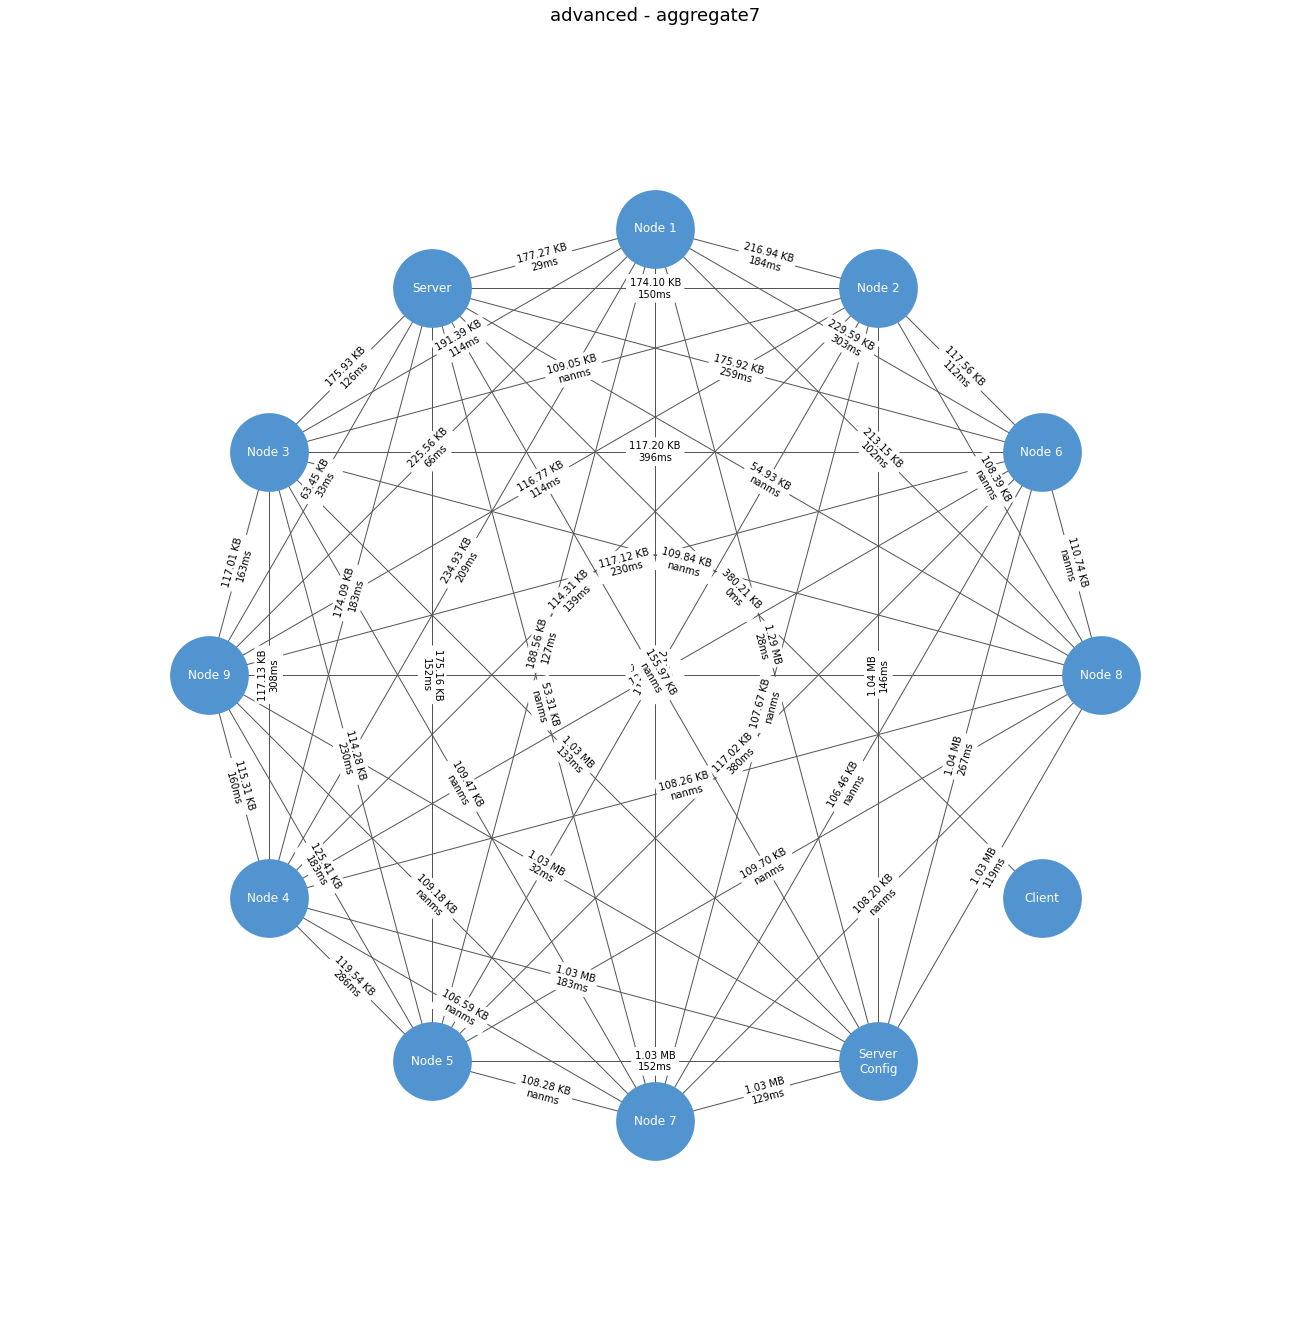

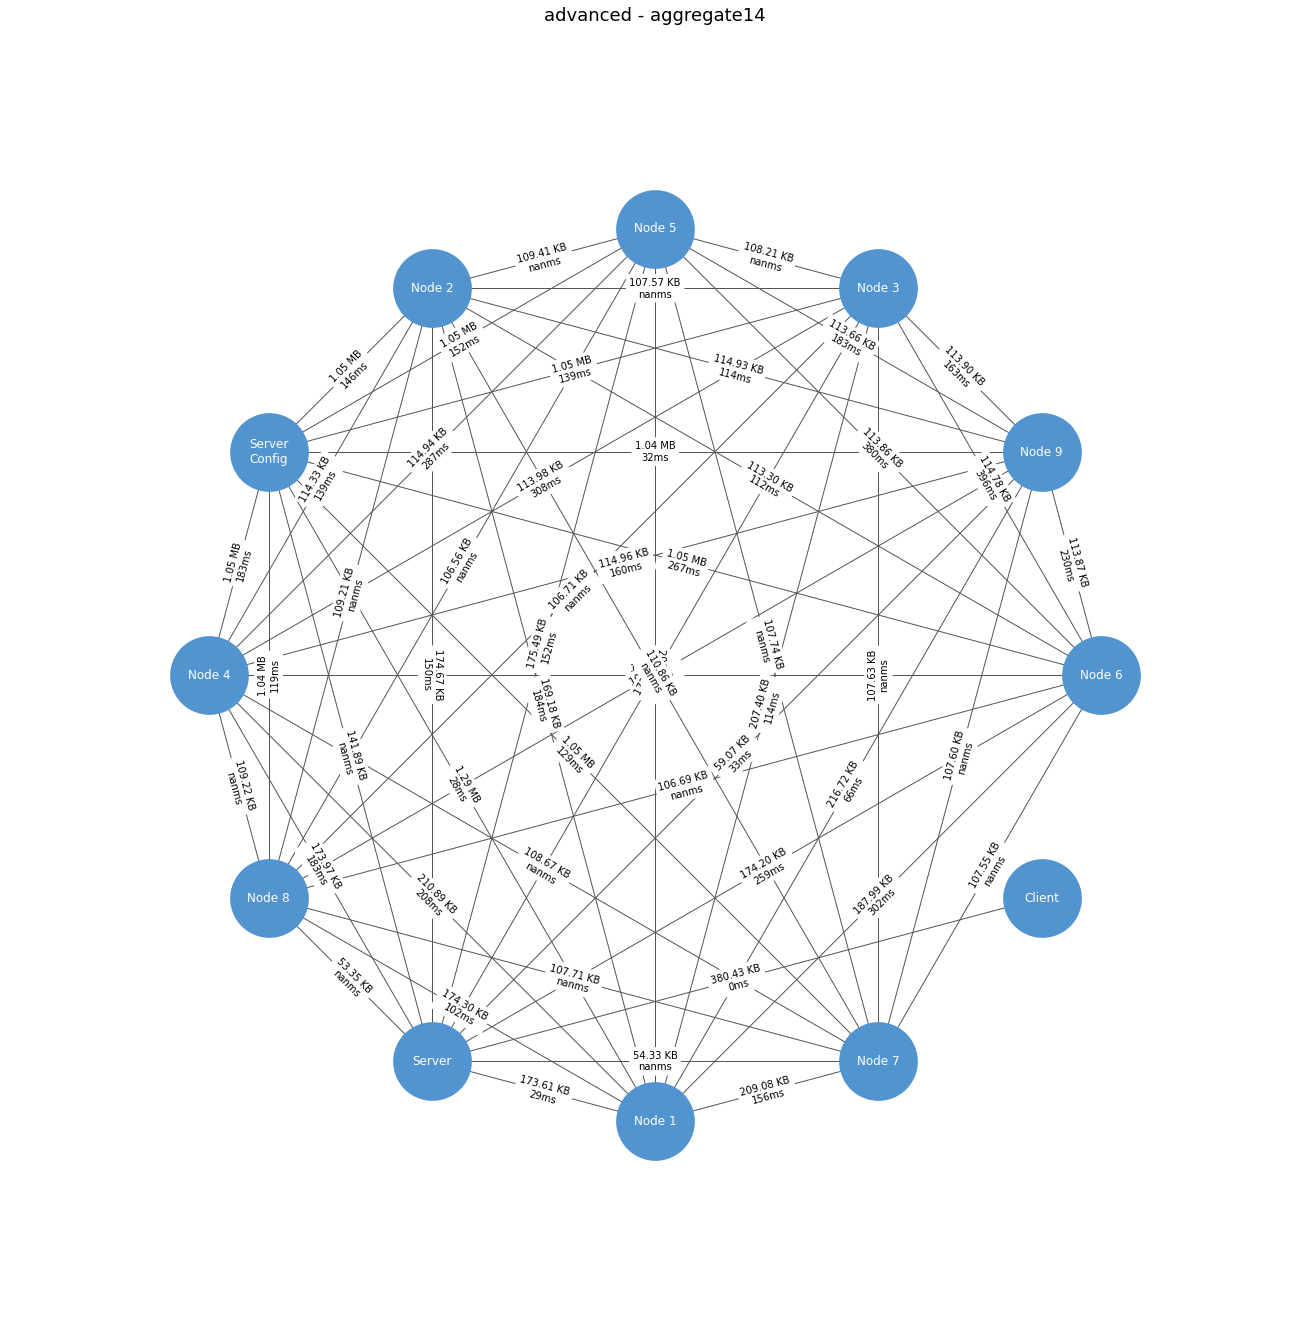

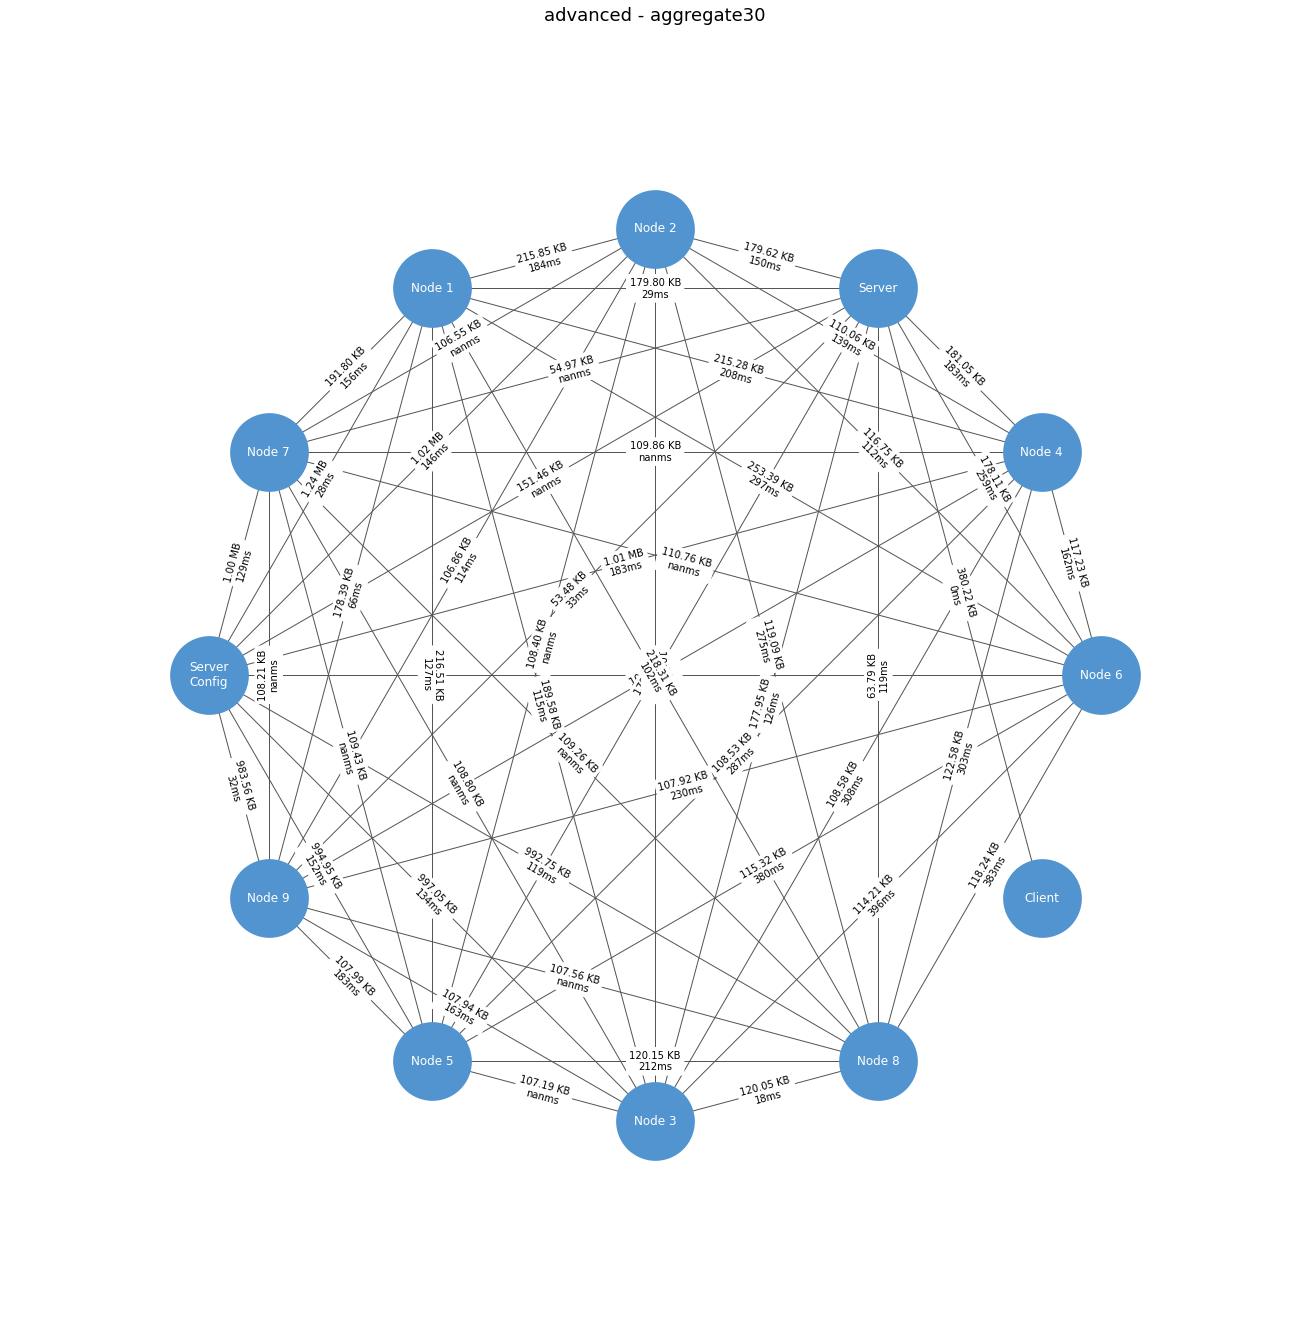

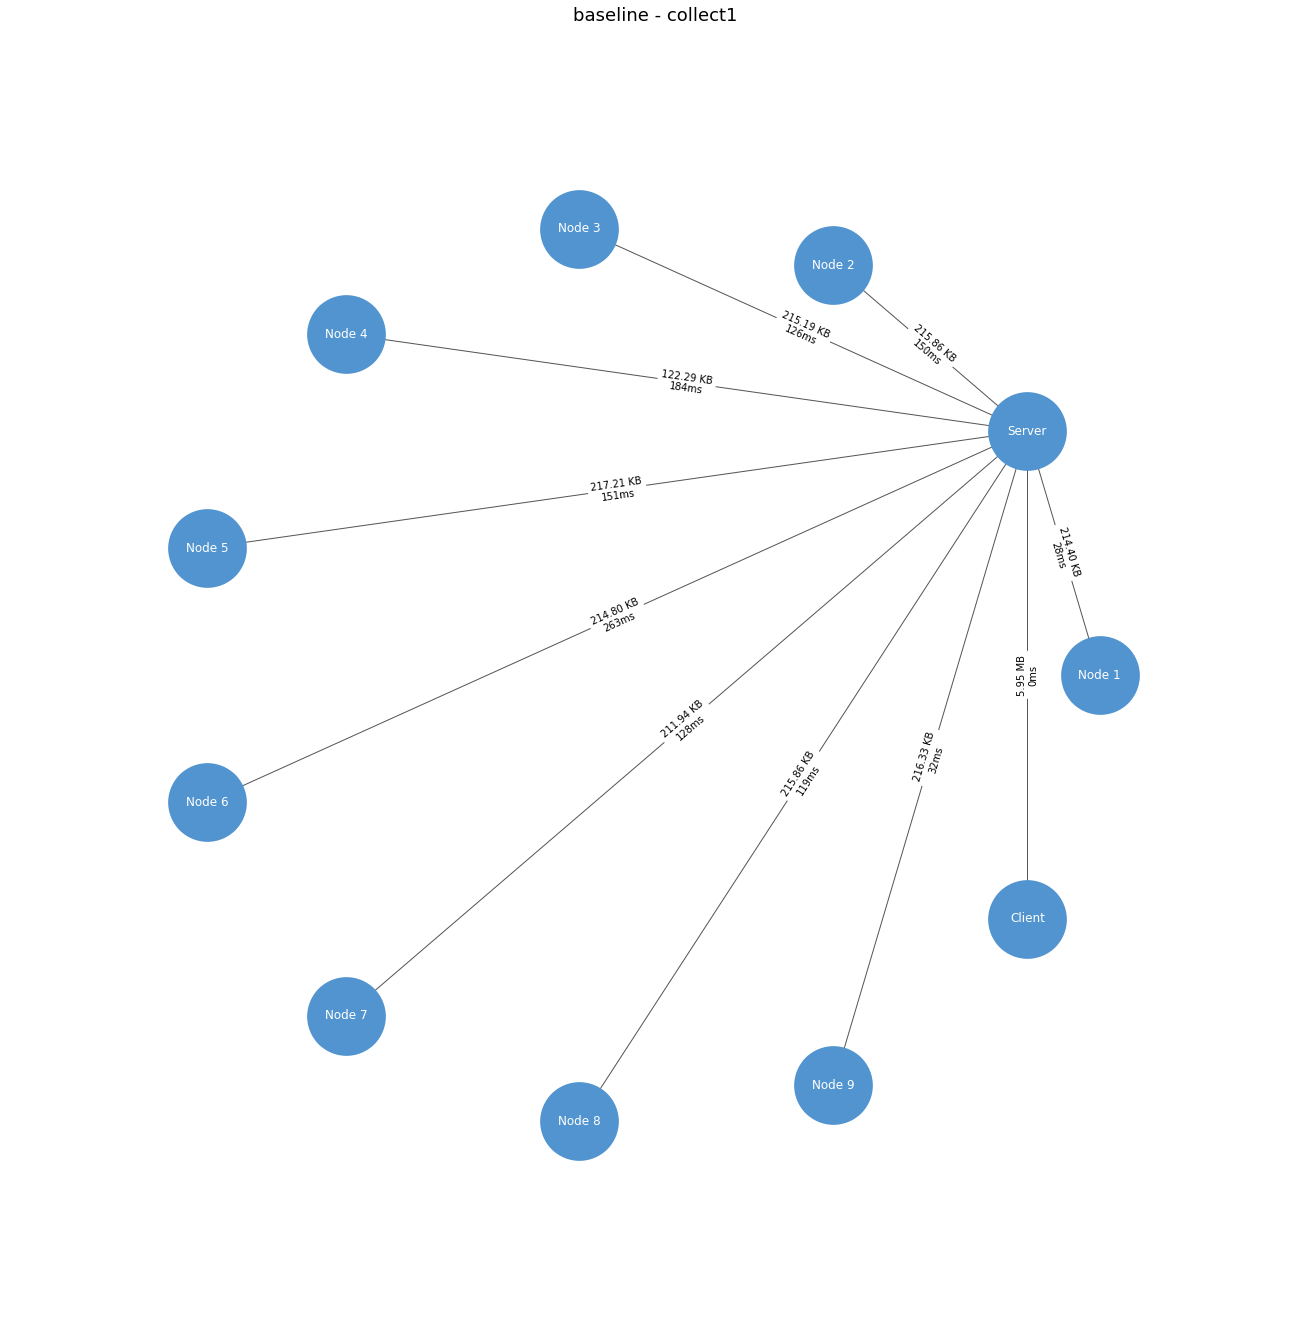

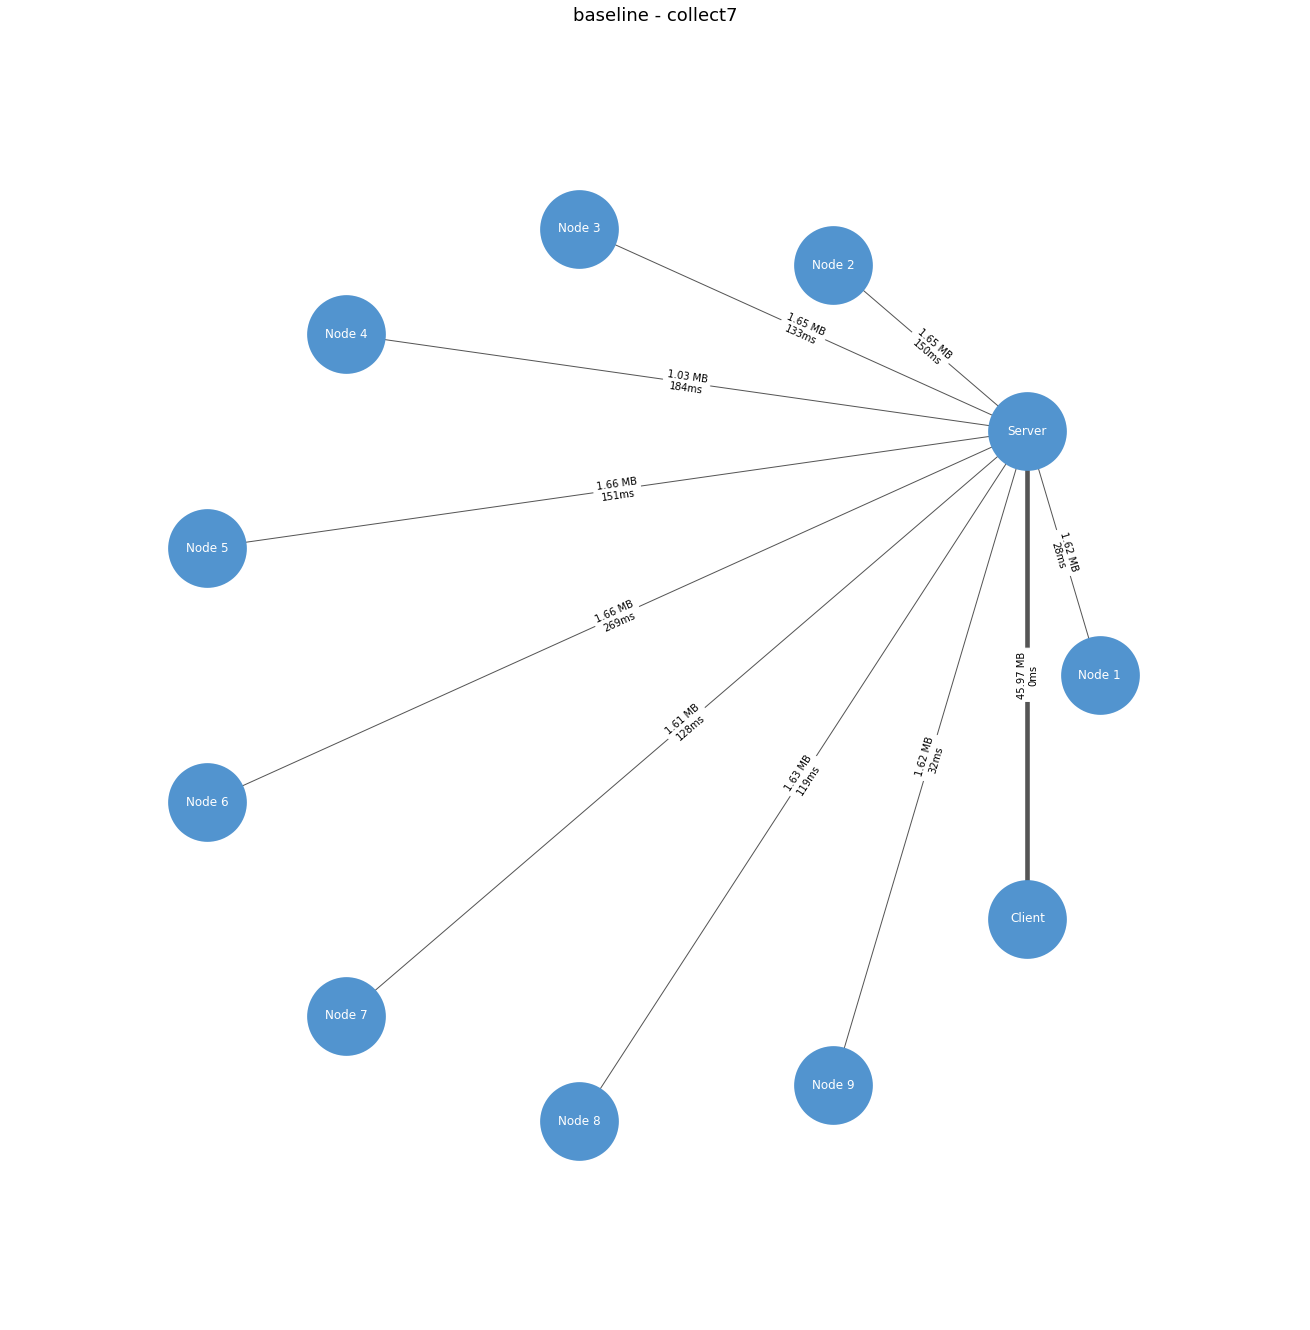

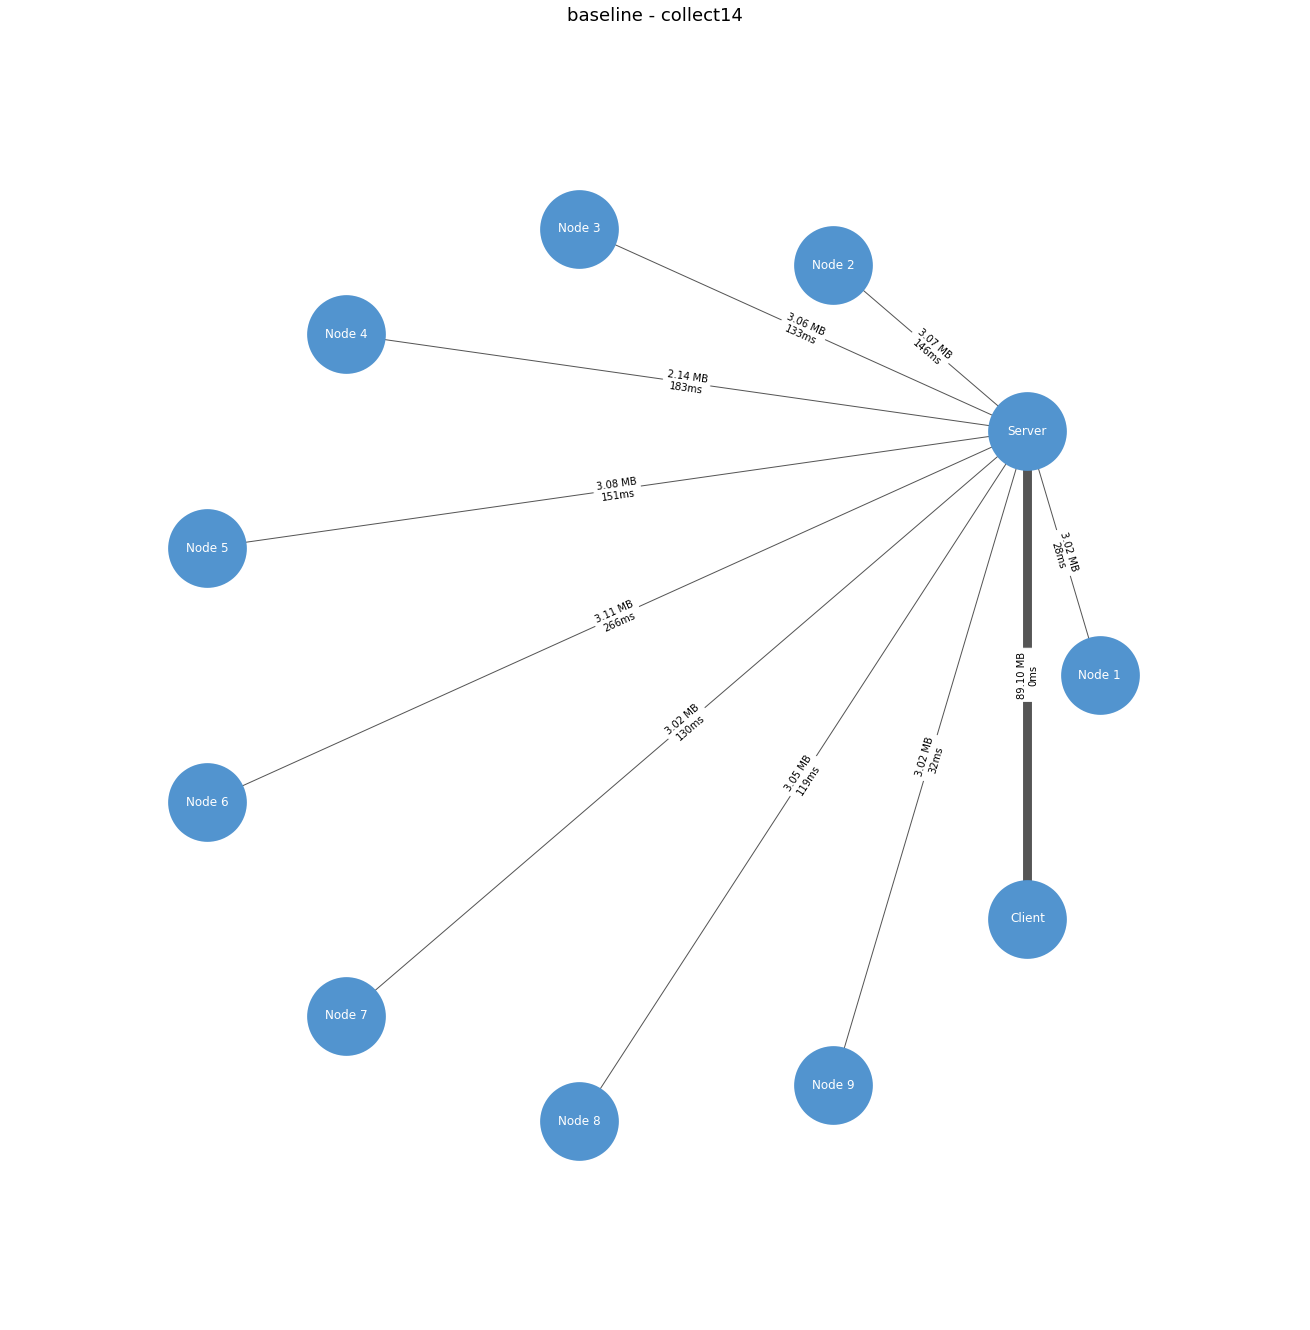

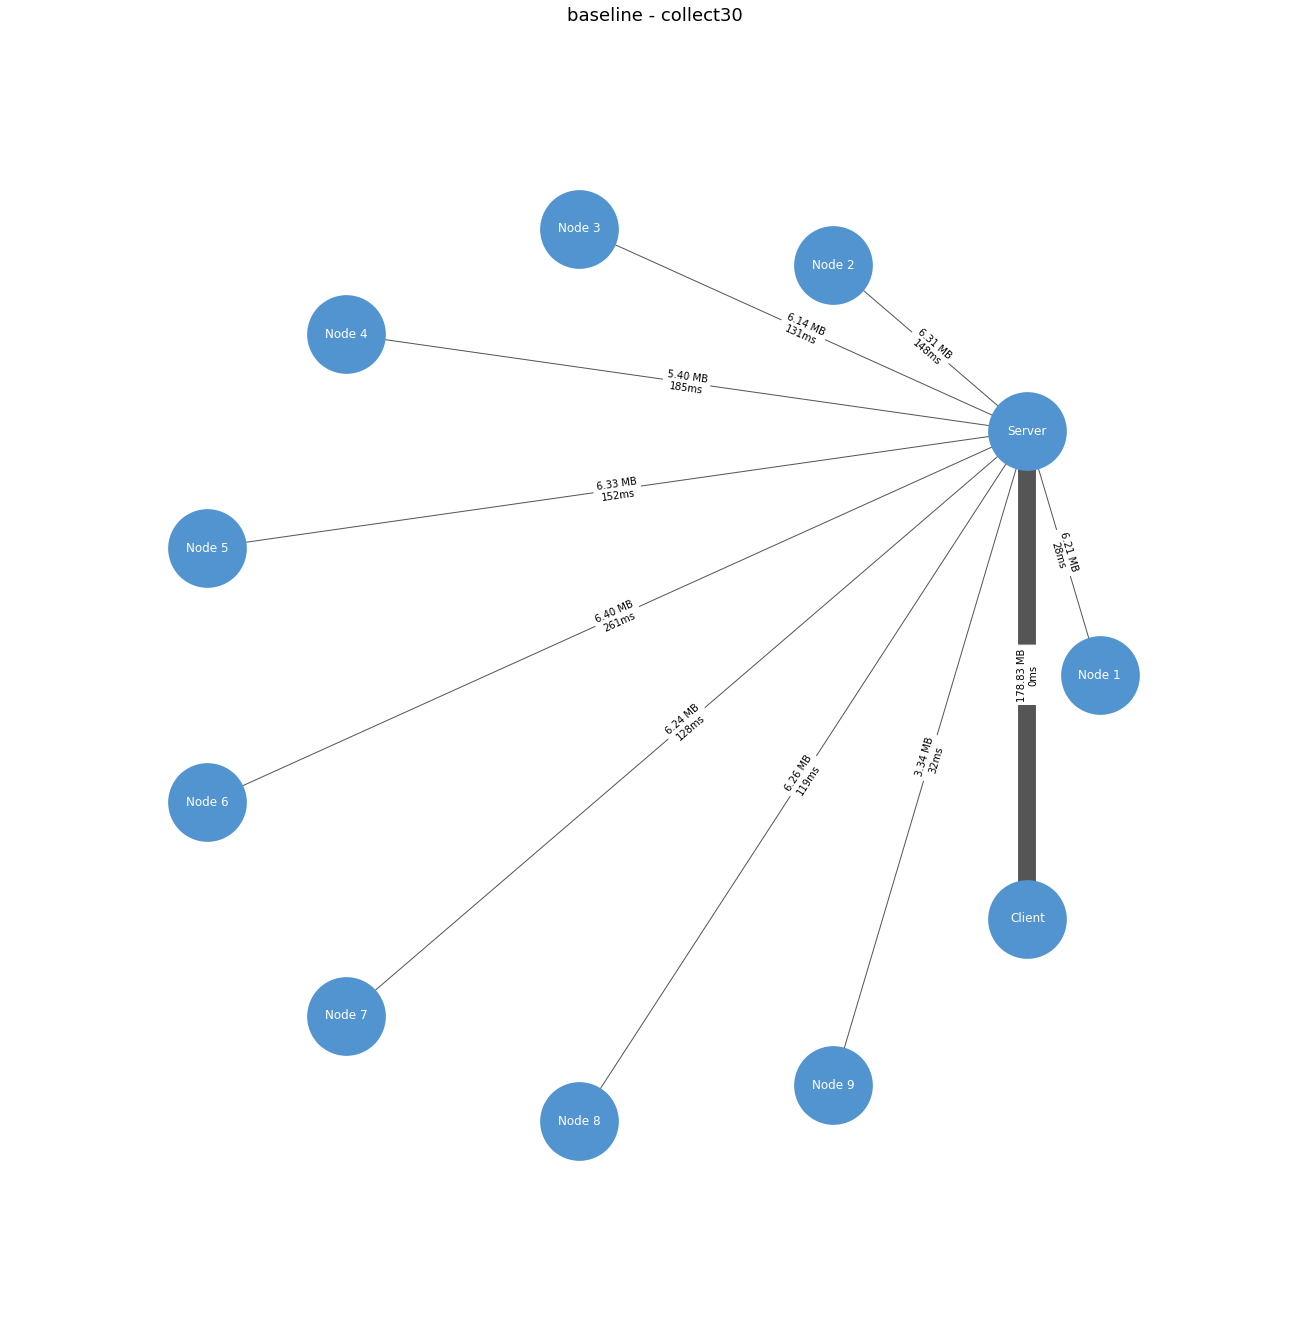

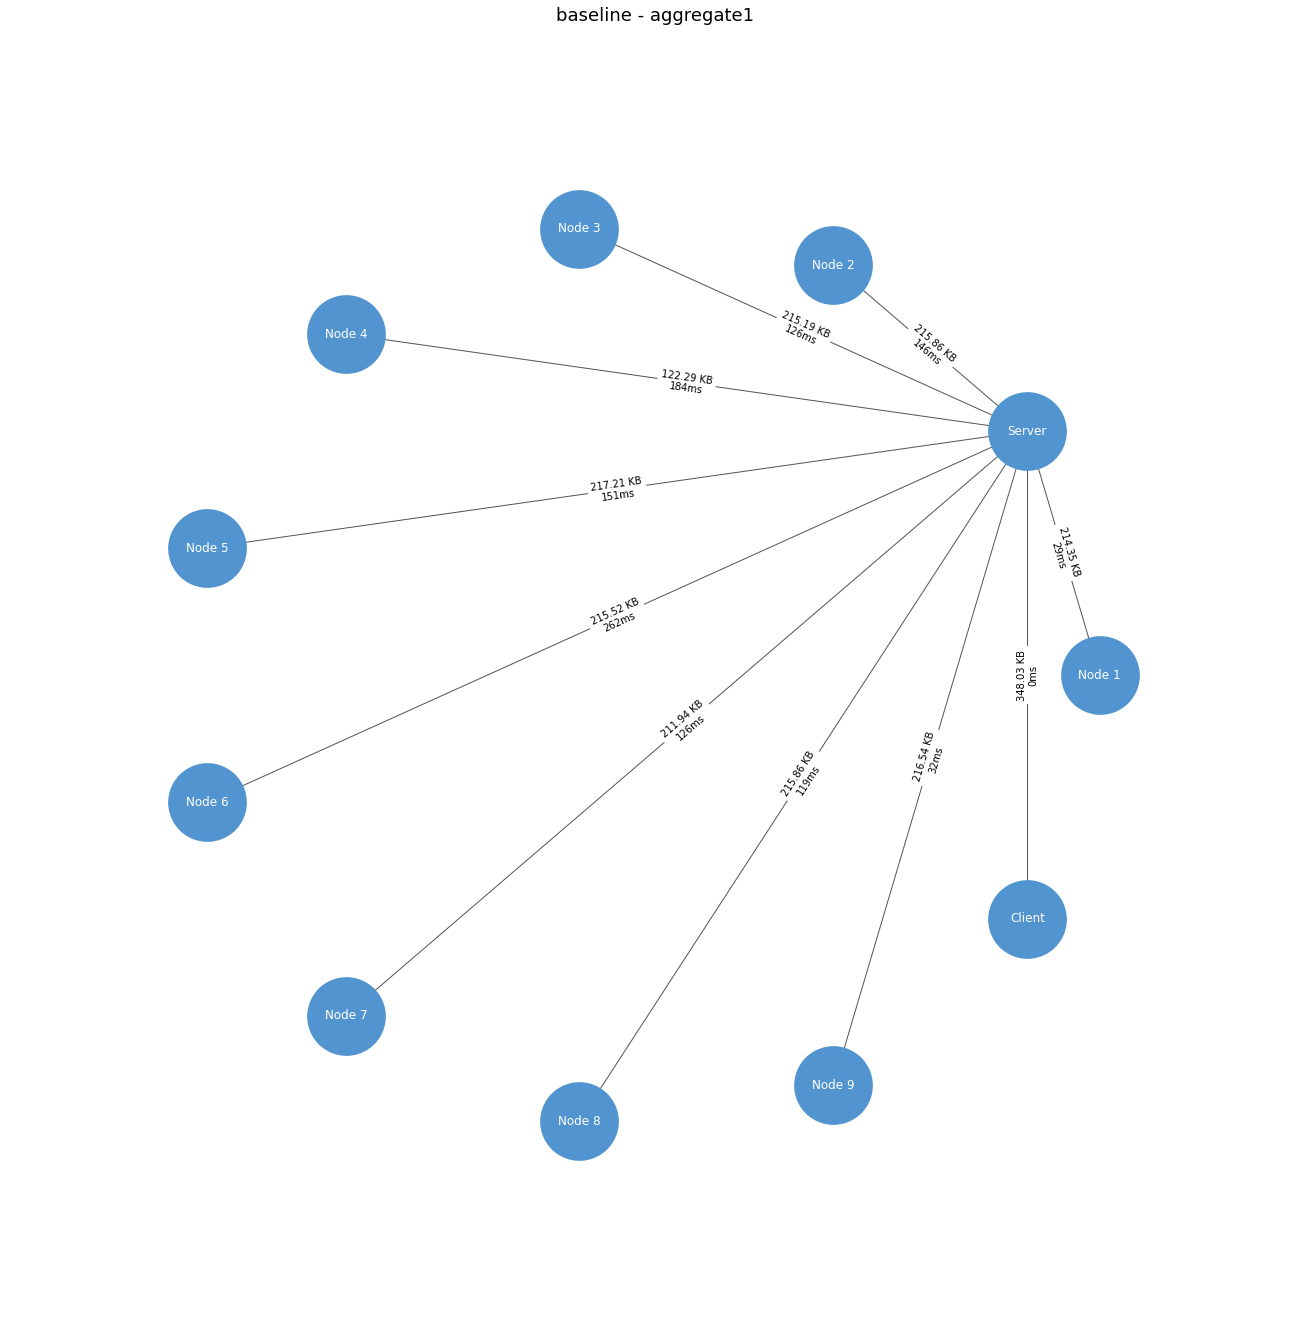

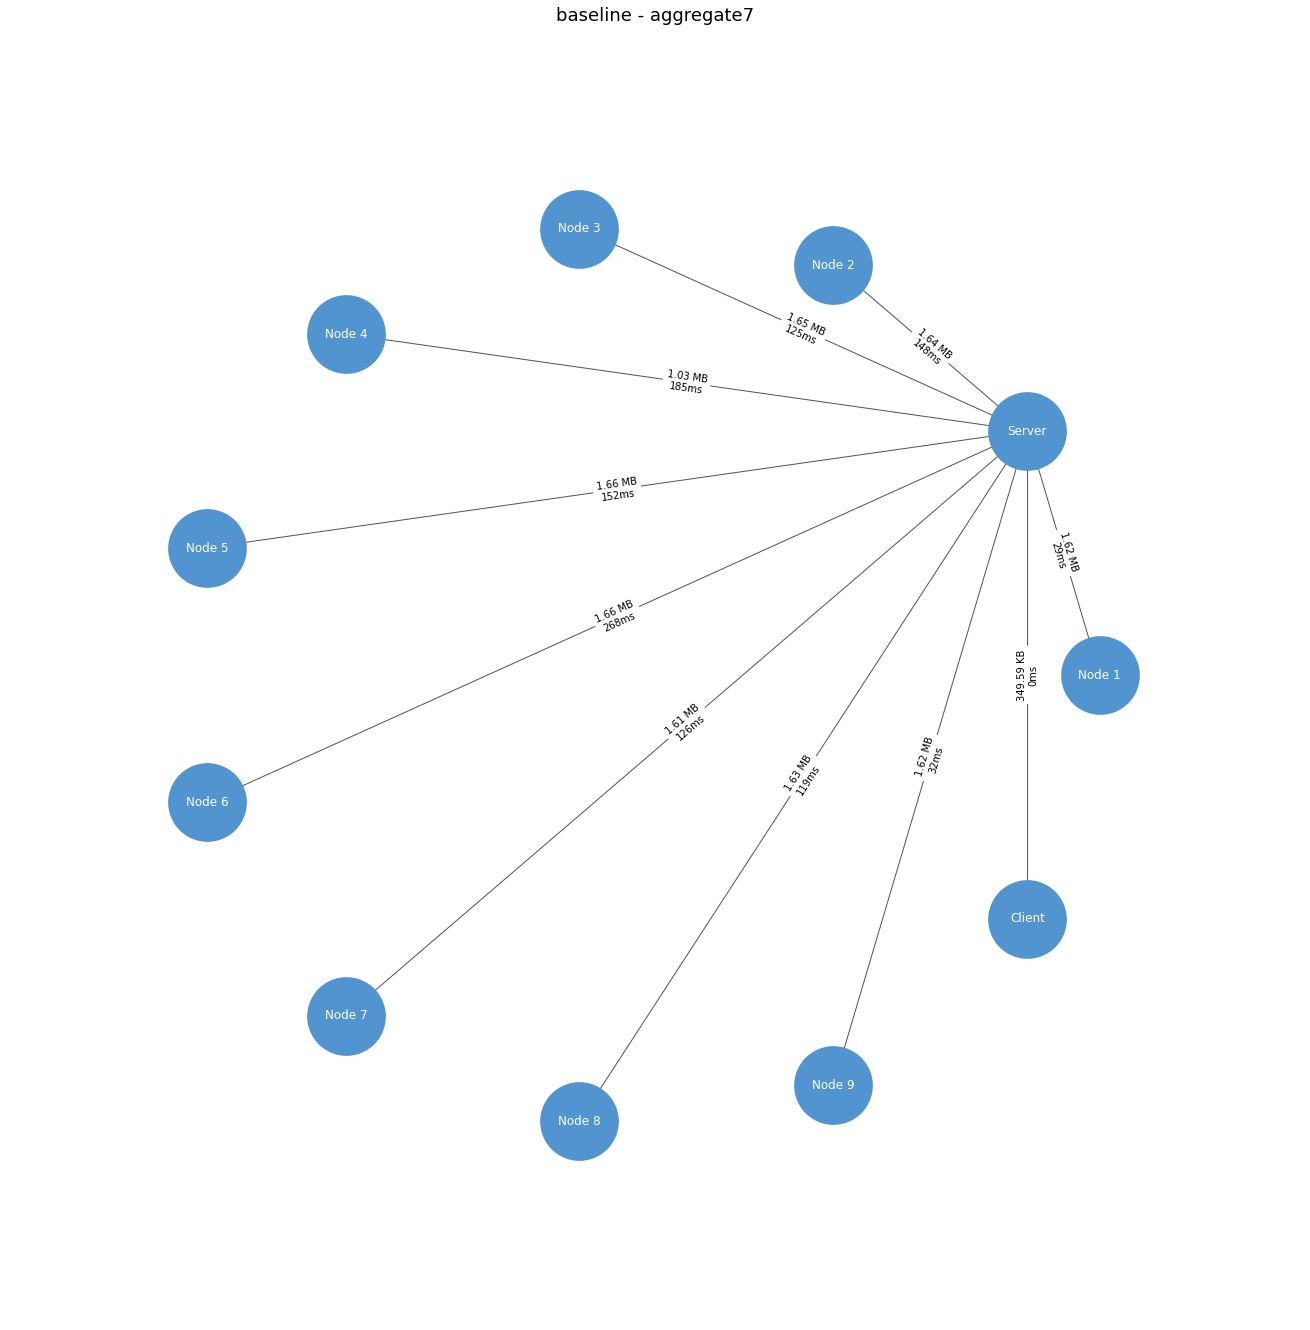

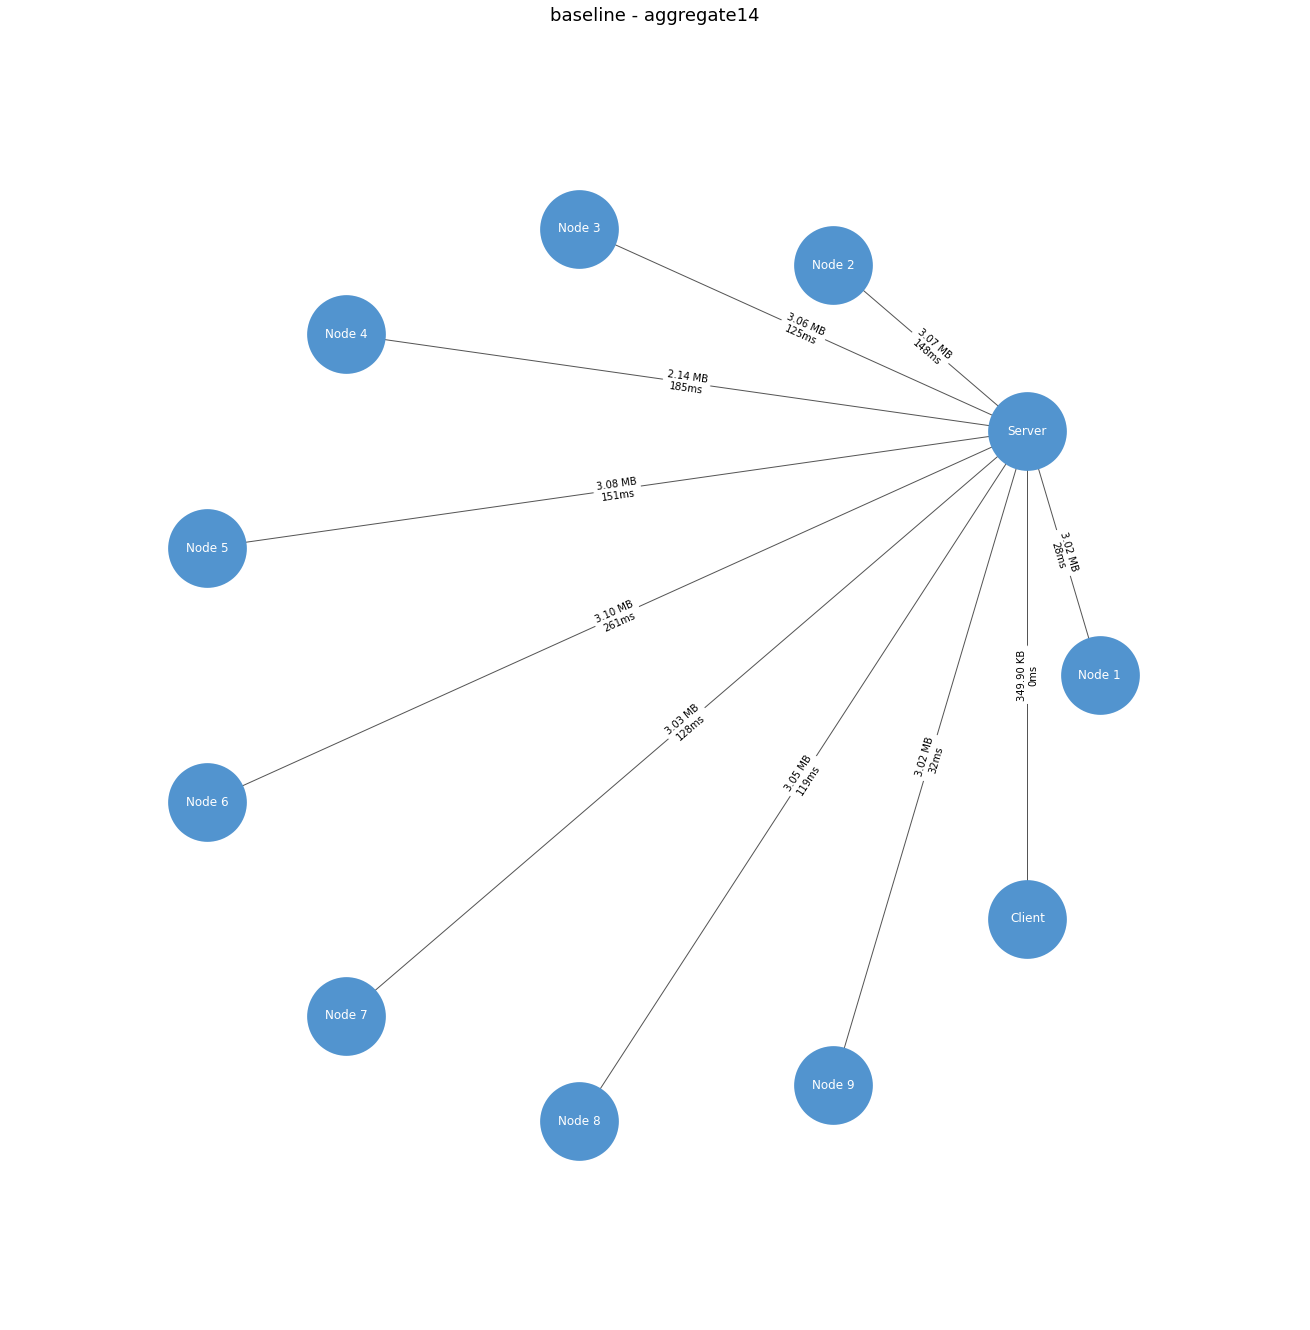

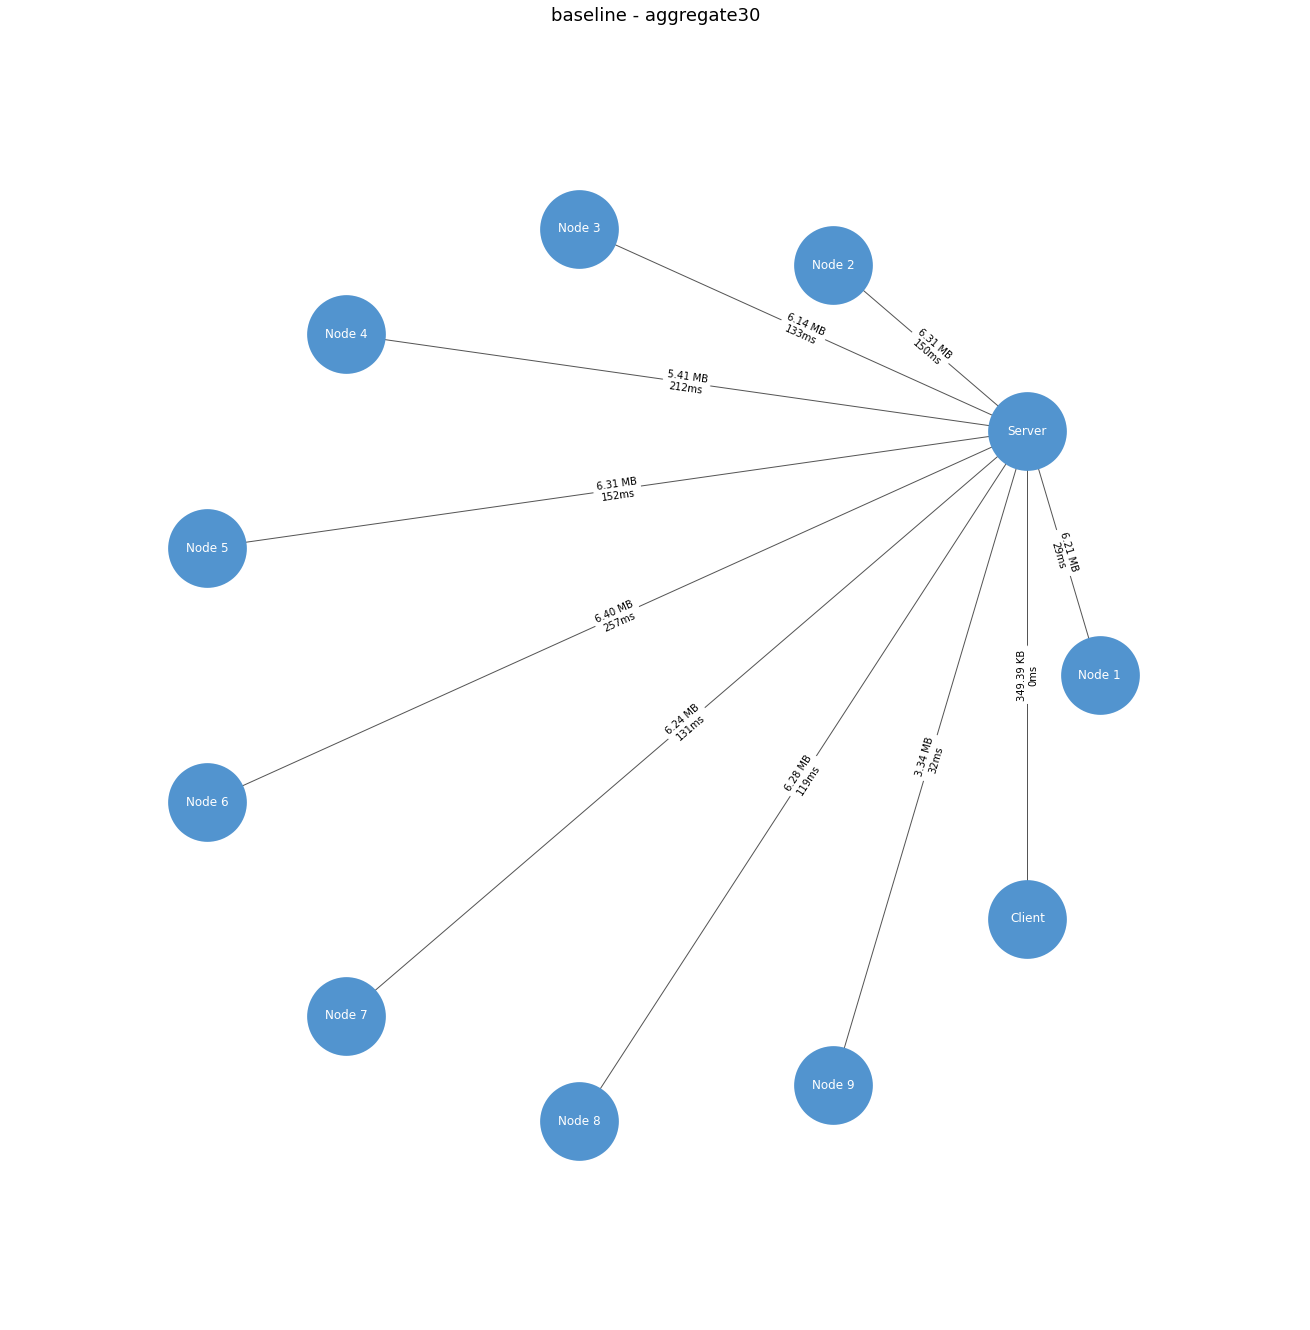

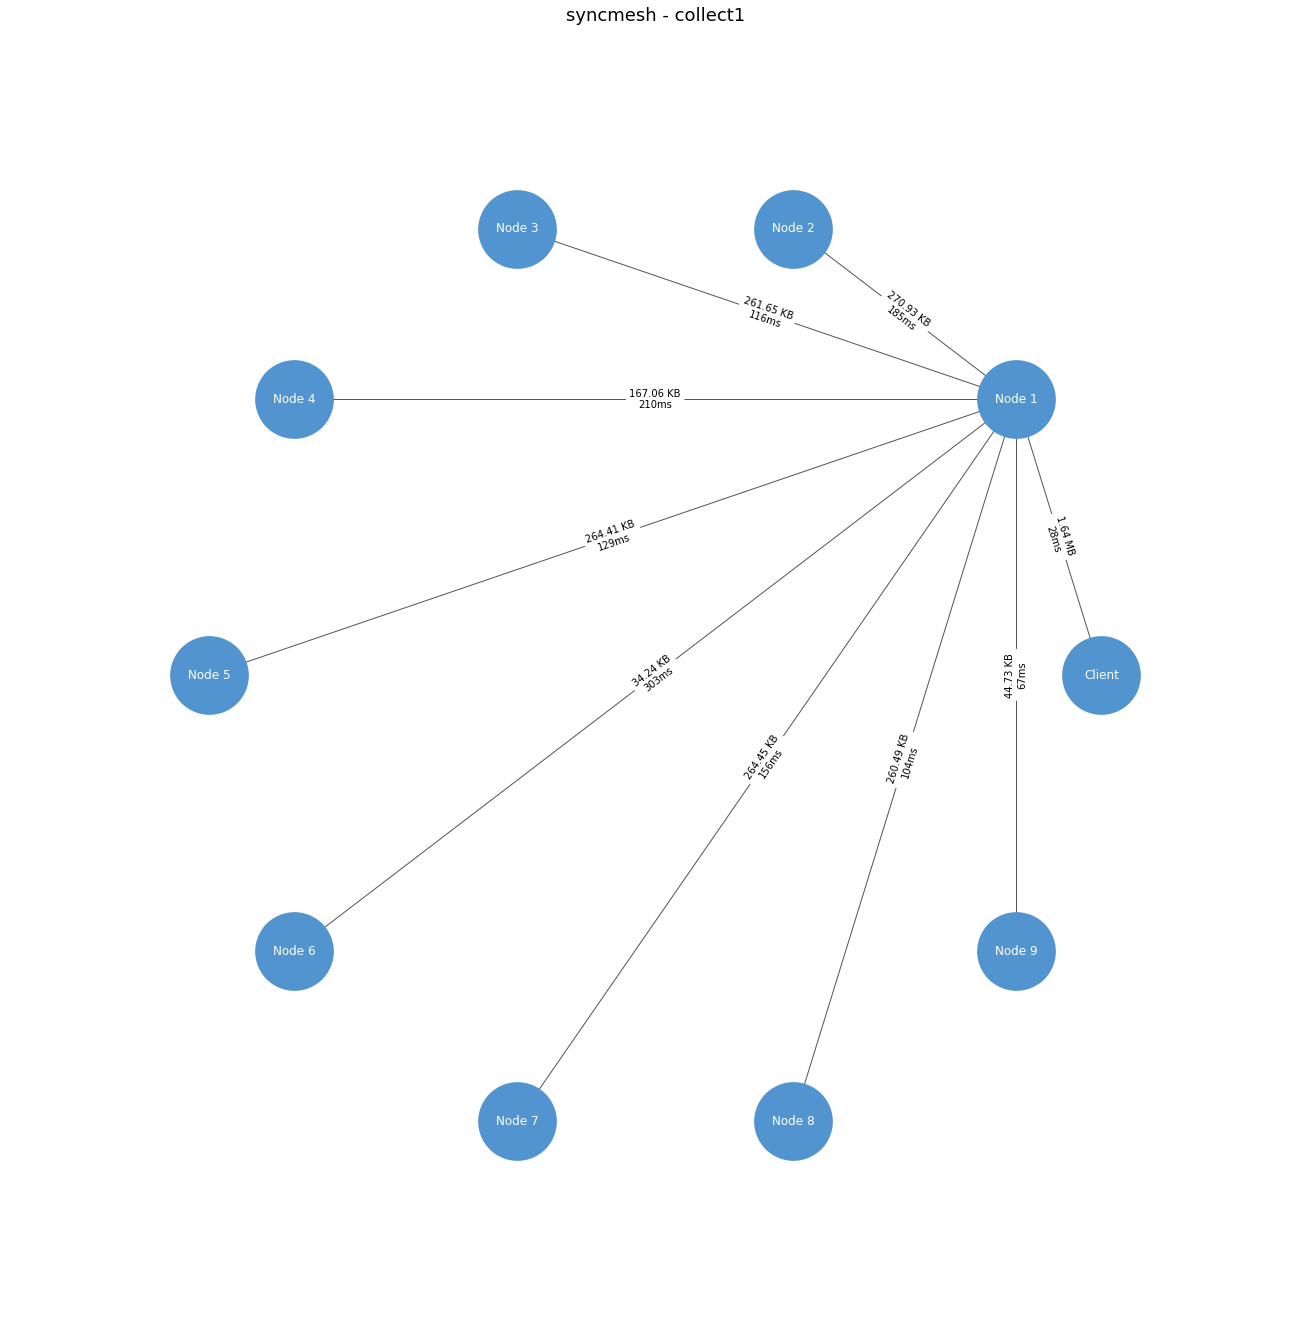

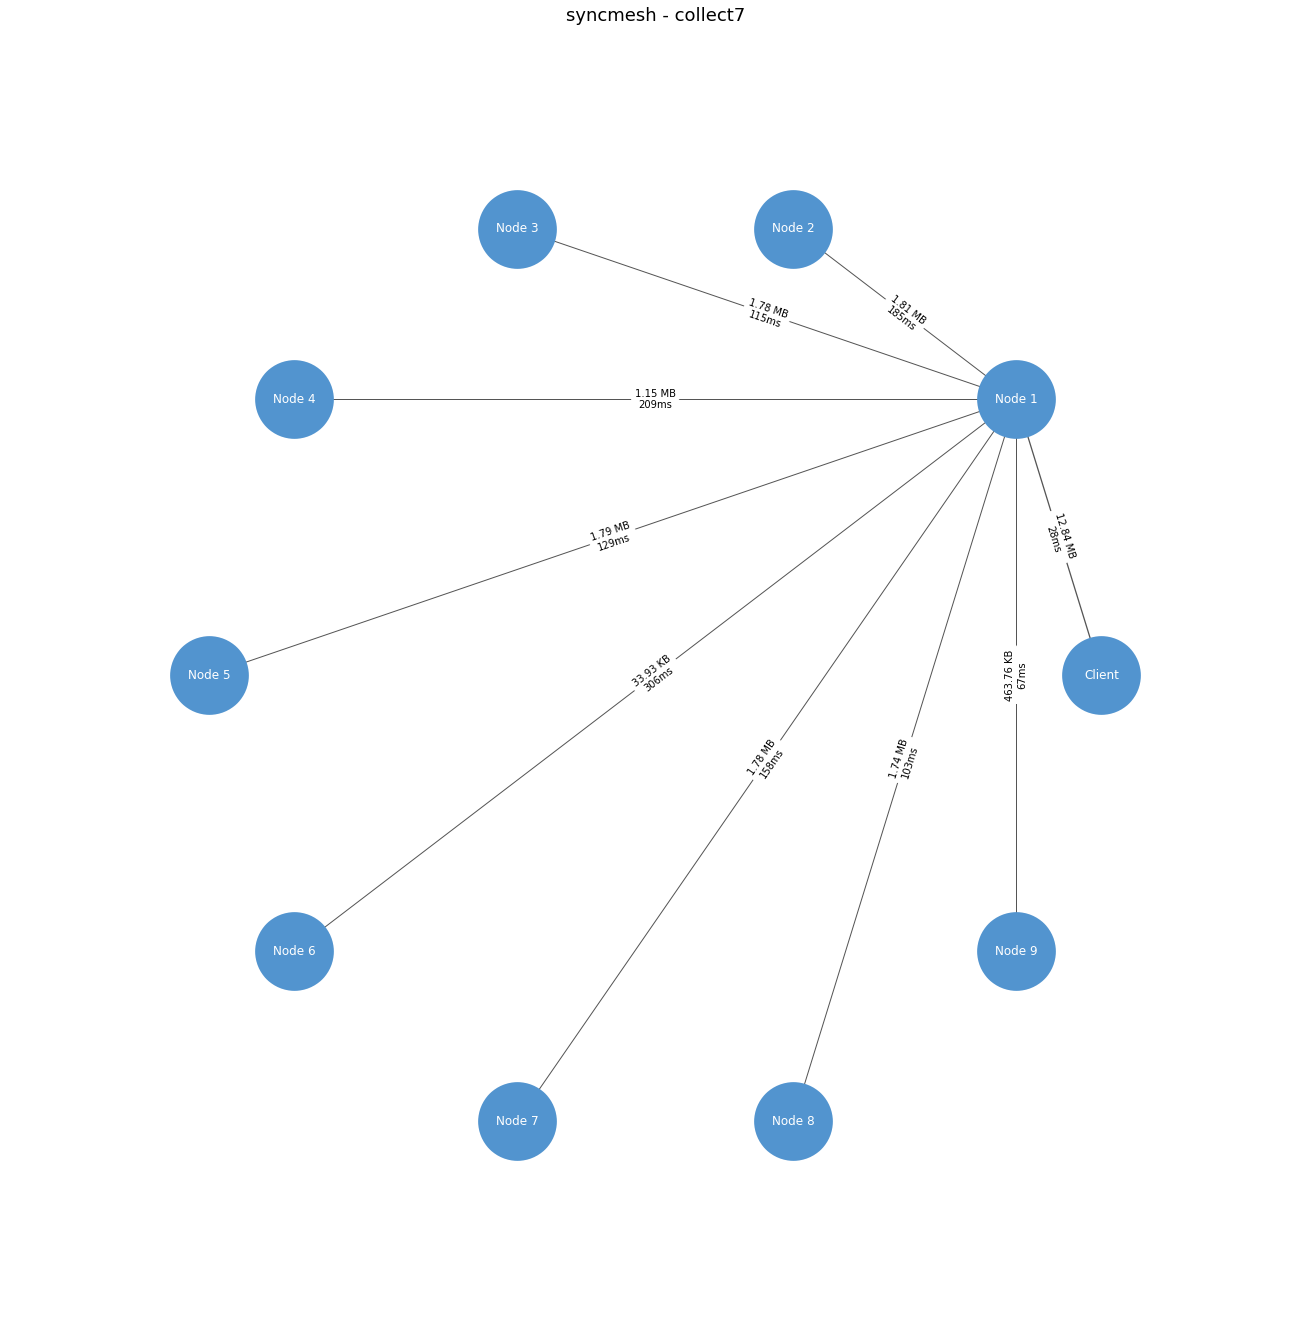

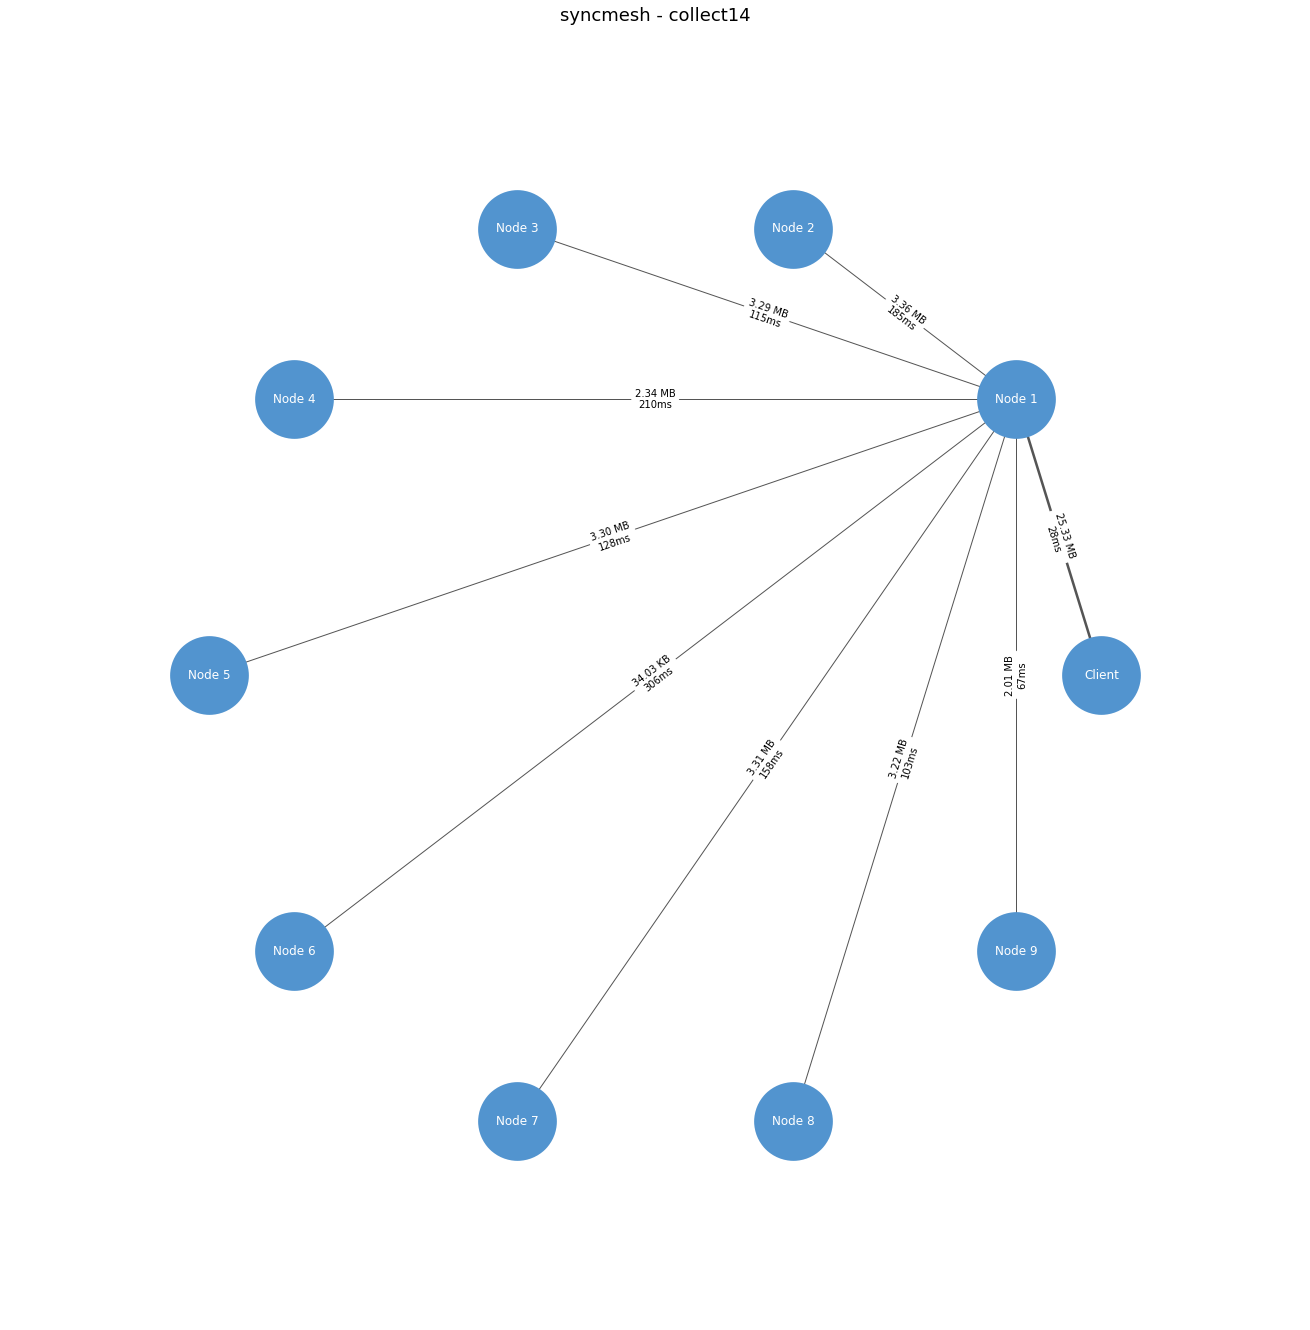

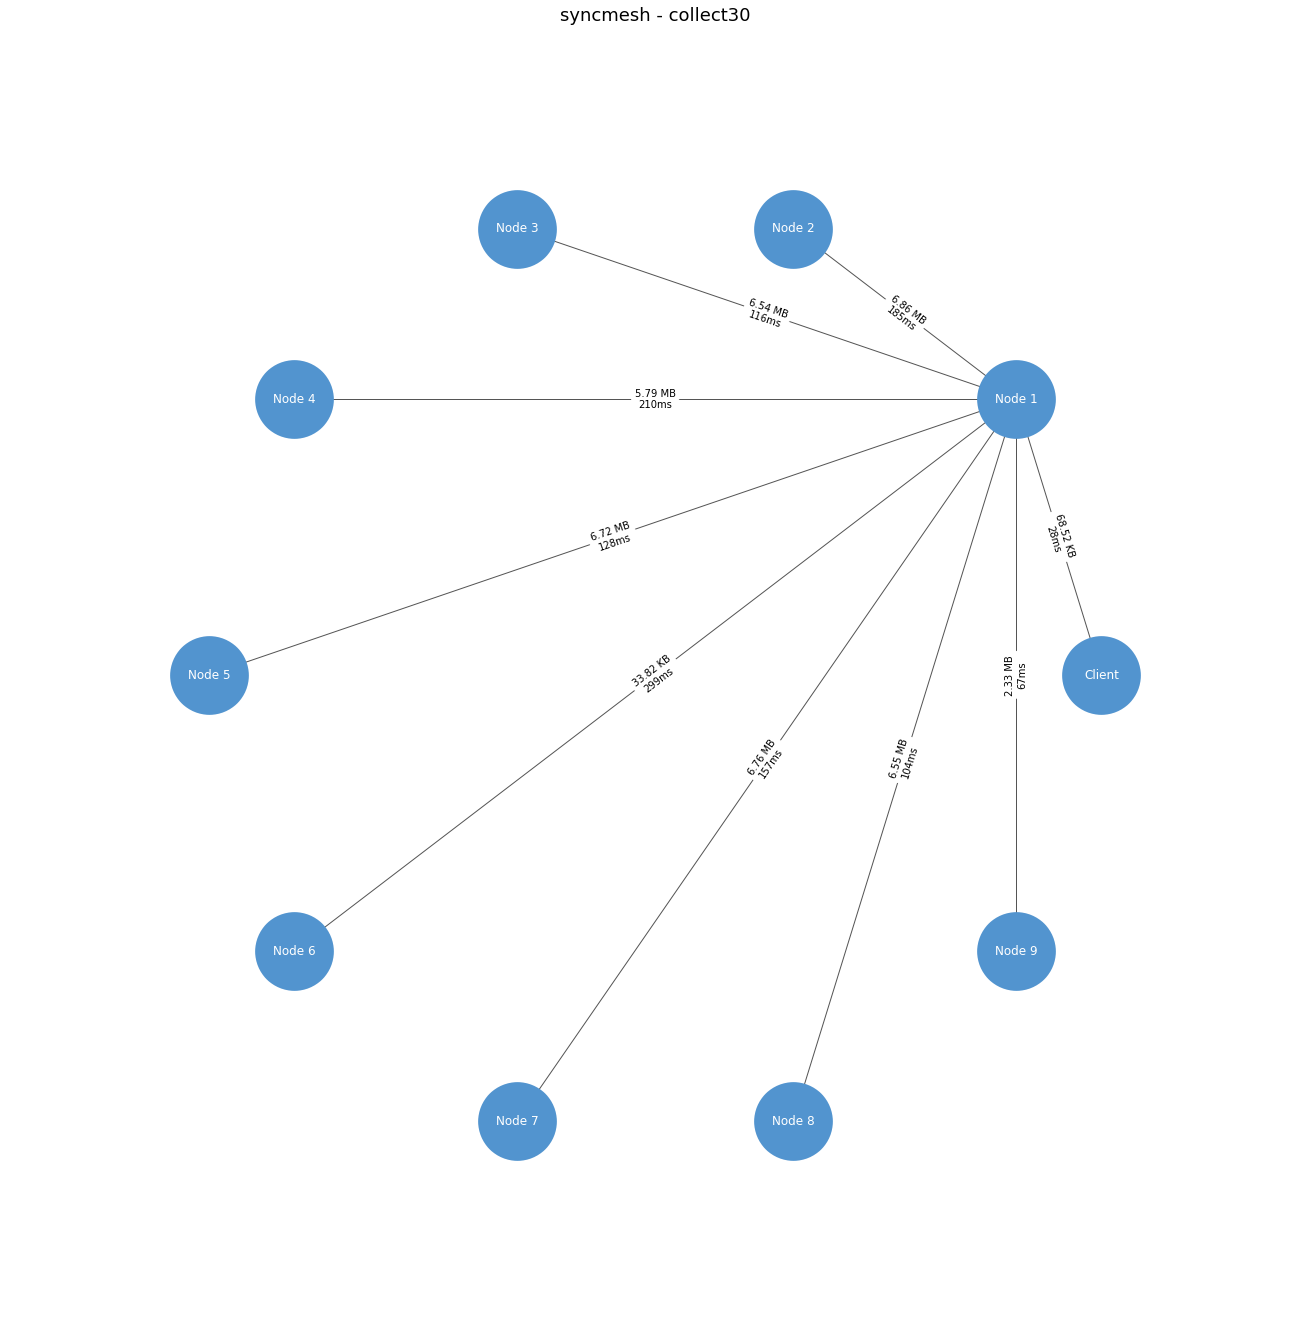

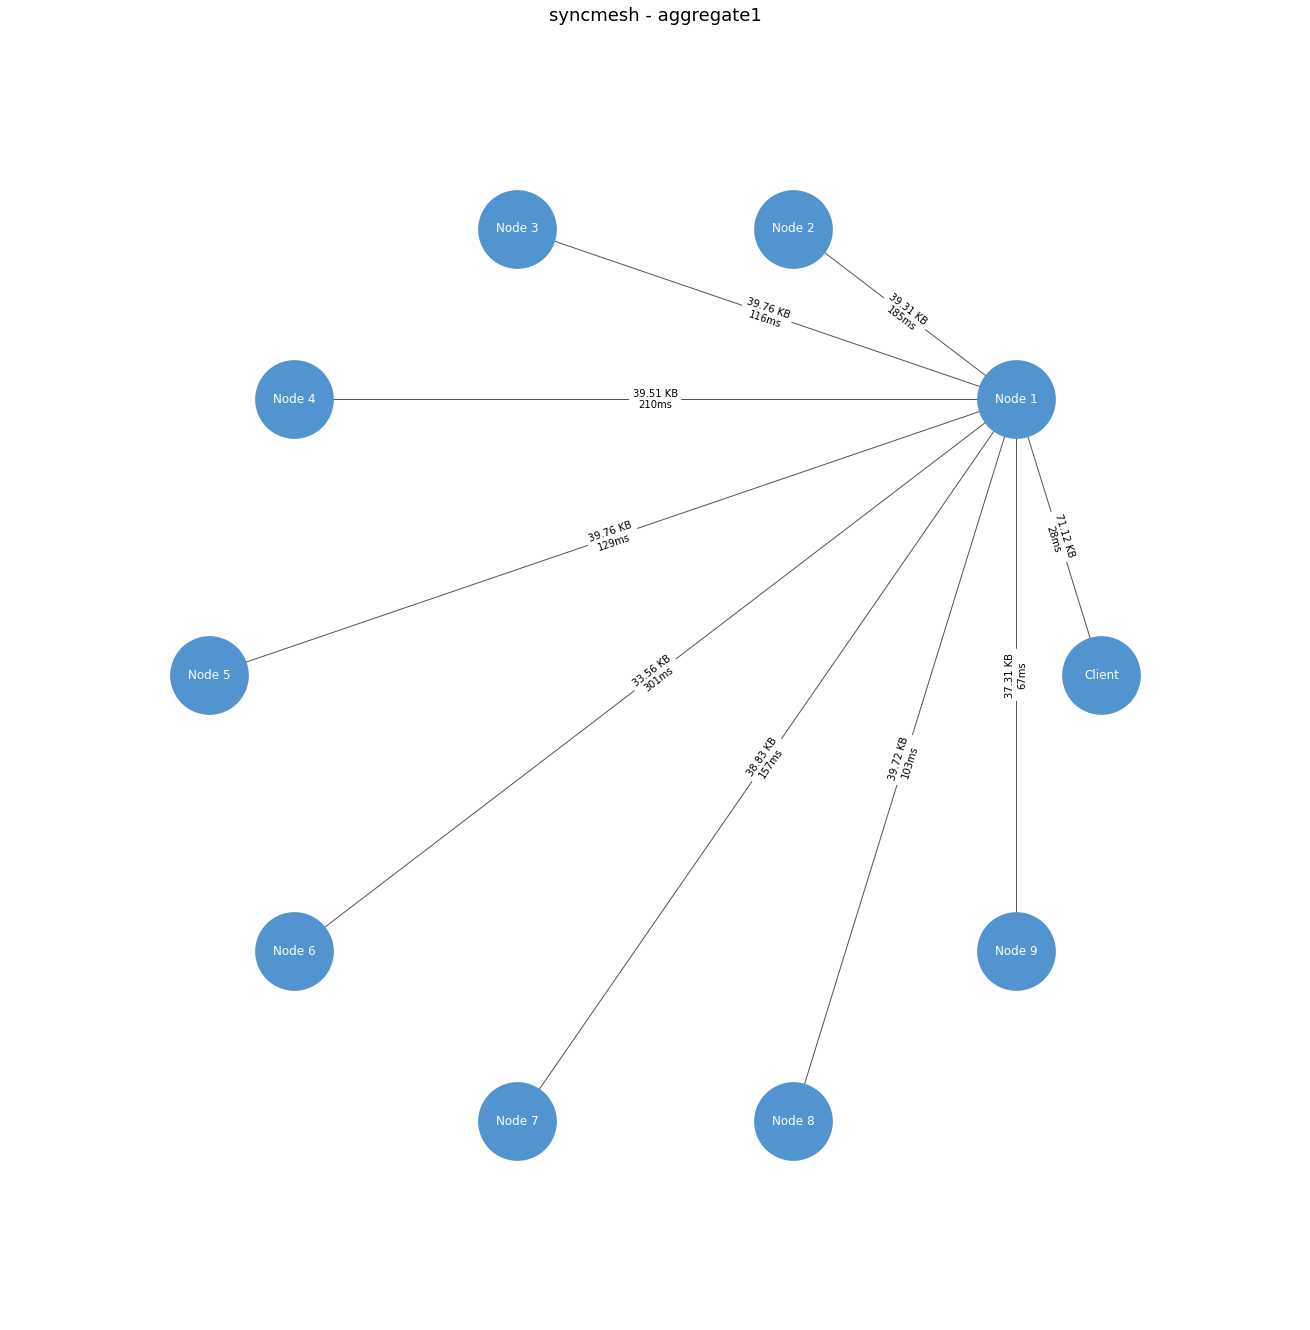

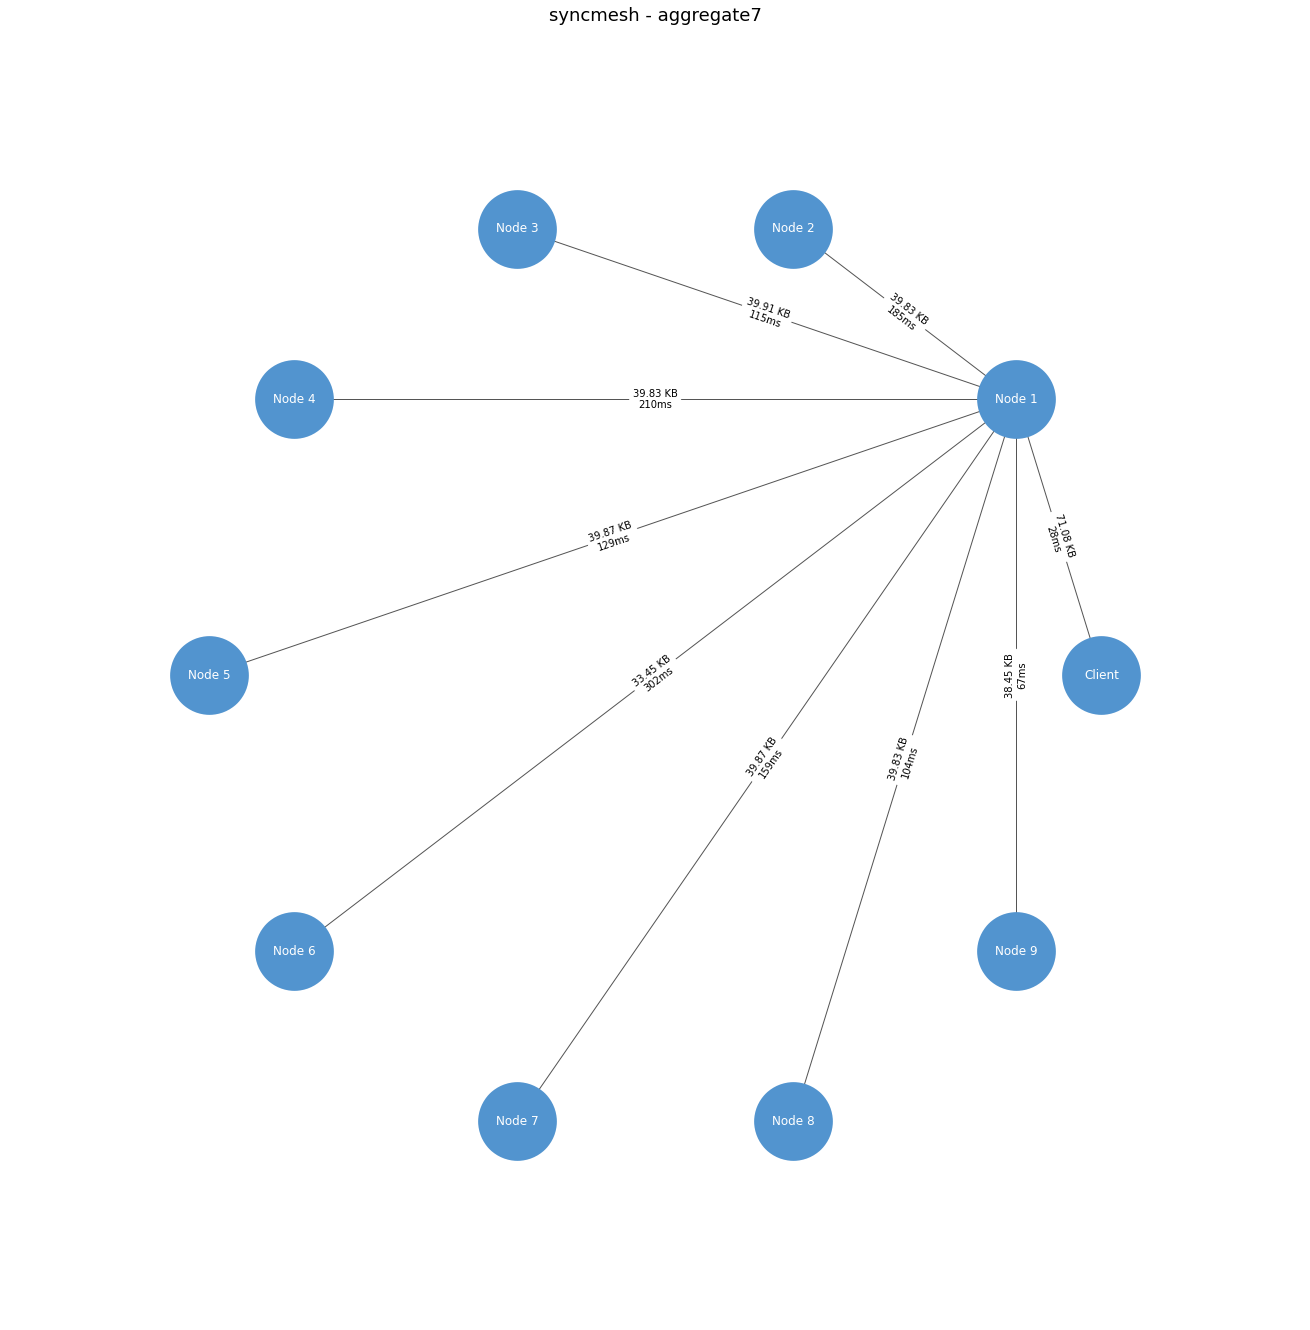

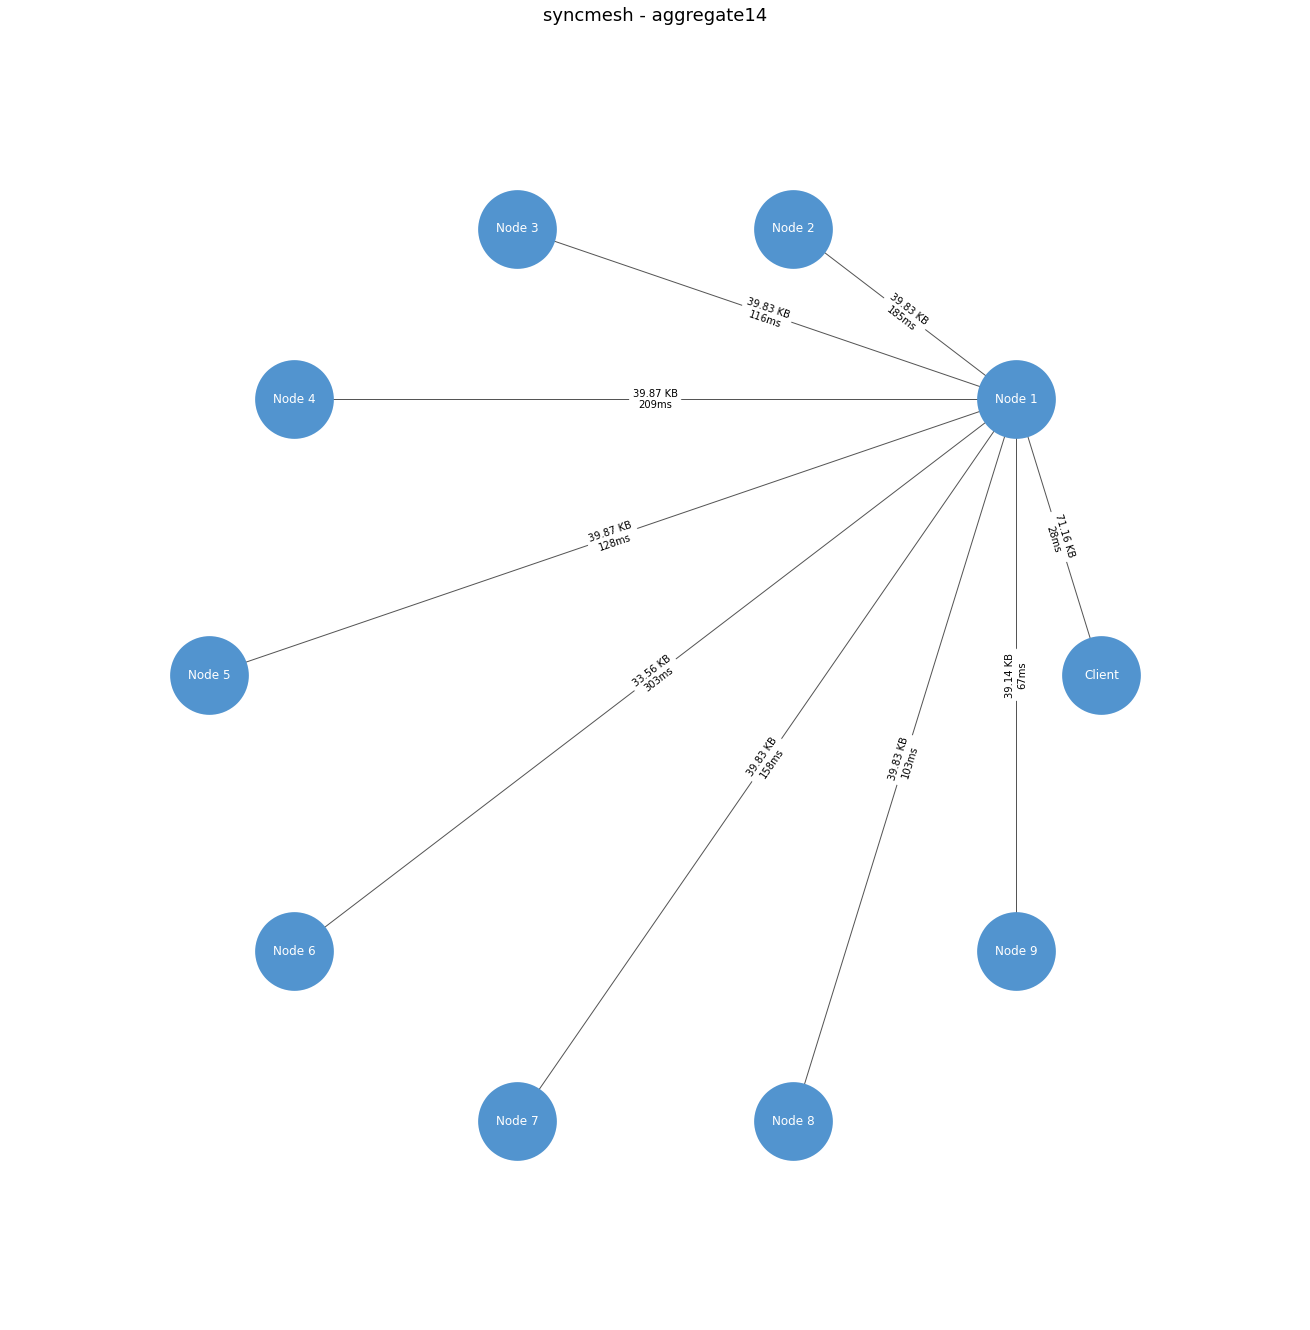

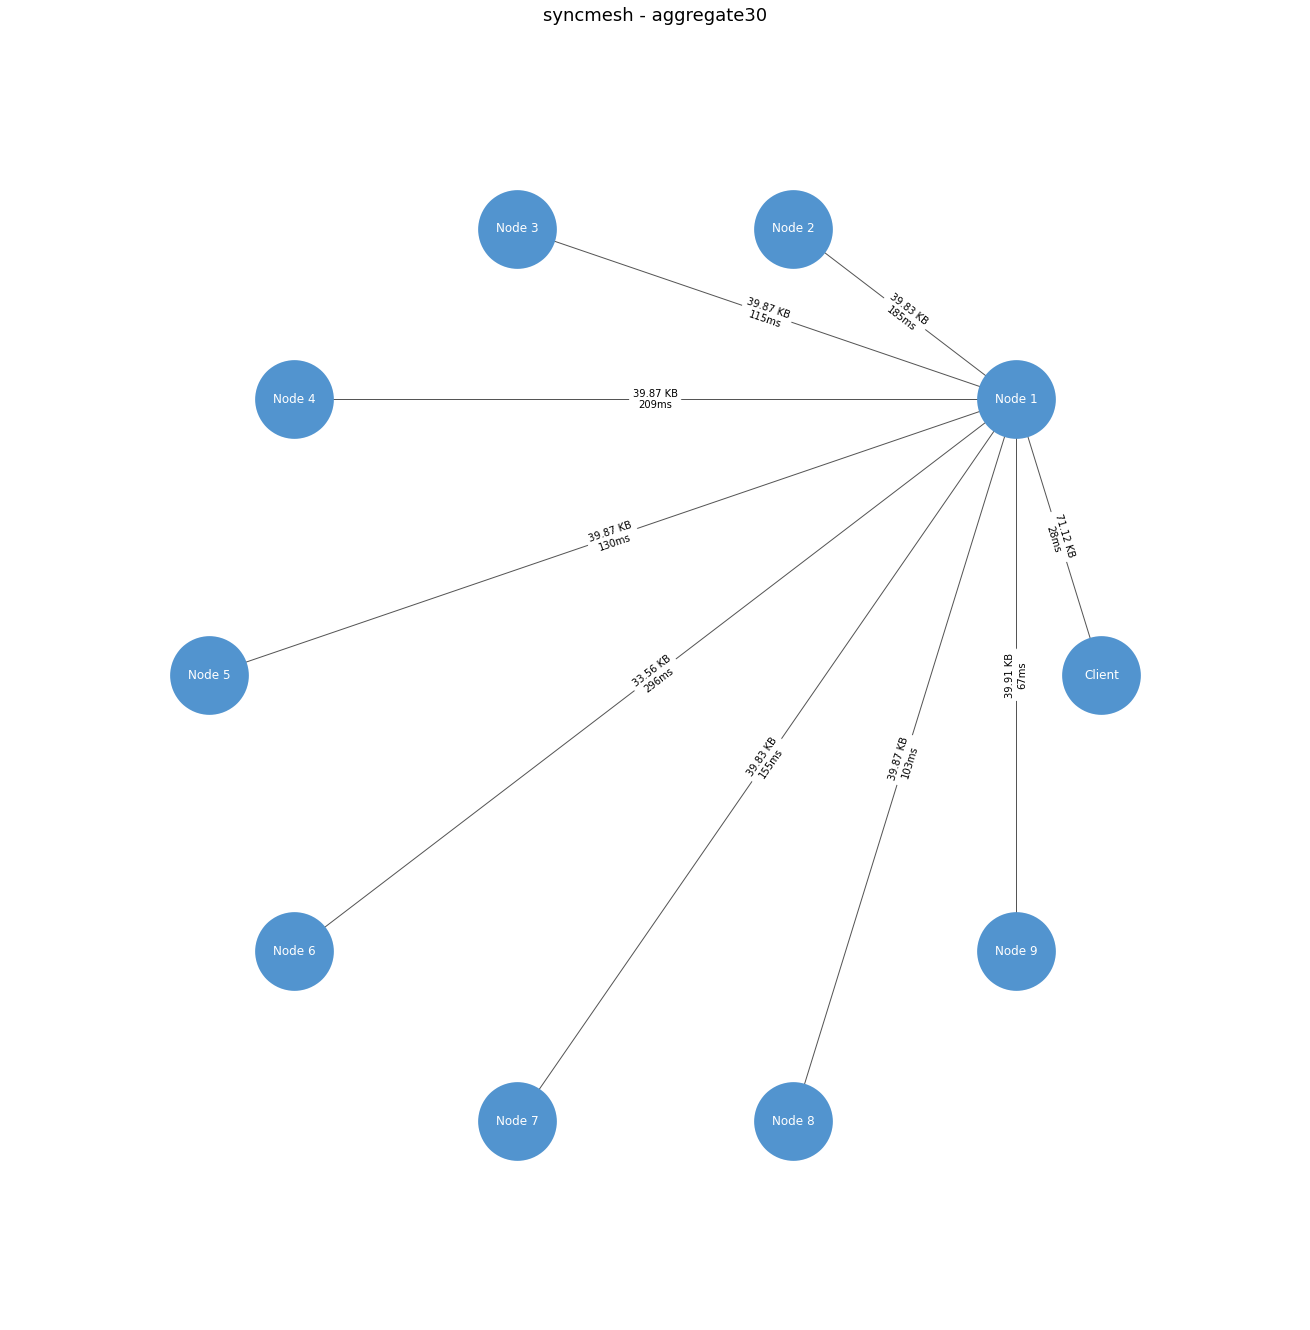

In [352]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        # print(experiment_key)
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            if len(subset["ip.dst"]) > 0:
                # print(node_dataset_key) 
                G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='#555555', weight=np.clip(subset["ip.len"].sum()/10000000 , 1, 1000), label=to_human_readable(subset["ip.len"].sum()) + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms")
                # print(subset["tcp.analysis.initial_rtt"].mean()* 1000)

        pos = nx.circular_layout(G)
        size=datasets[subset_key][2]/3 * 6
        plt.figure(int(str(index)+str(e_index)),figsize=(size,size))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="#5294CF", font_color="w", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        plt.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

# node_experiment_datasets
# plt.show()

In [353]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


subset_col = []
experiment_group_col = []
experiment_col = []
traffic_col = []
rtt_col = []
print("Aggregated Traffic")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        subset_col.append(subset_key)   
        experiment_group_col.append(experiment_key.translate(remove_digits))
        experiment_col.append(experiment_key)
        sum_bytes = 0
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            sum_bytes = sum_bytes + subset["ip.len"].sum()

        traffic_col.append(sum_bytes)
        print(subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

print("Median RTT")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        rtt = np.array([])
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

        # print(rtt)
        rtt_col.append(np.nanmean(rtt) * 1000)
        print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))

Aggregated Traffic
advanced - collect1: 24.49 MB
advanced - collect7: 82.69 MB
advanced - collect14: 142.82 MB
advanced - collect30: 281.63 MB
advanced - aggregate1: 16.17 MB
advanced - aggregate7: 16.19 MB
advanced - aggregate14: 16.09 MB
advanced - aggregate30: 15.85 MB
baseline - collect1: 7.79 MB
baseline - collect7: 60.09 MB
baseline - collect14: 115.69 MB
baseline - collect30: 231.45 MB
baseline - aggregate1: 2.19 MB
baseline - aggregate7: 14.47 MB
baseline - aggregate14: 26.92 MB
baseline - aggregate30: 52.99 MB
syncmesh - collect1: 3.21 MB
syncmesh - collect7: 23.39 MB
syncmesh - collect14: 46.18 MB
syncmesh - collect30: 41.65 MB
syncmesh - aggregate1: 378.88 KB
syncmesh - aggregate7: 382.12 KB
syncmesh - aggregate14: 382.91 KB
syncmesh - aggregate30: 383.72 KB
Median RTT
advanced - collect1: 139.57124802375546 msec nan
advanced - collect7: 139.44318611210505 msec nan
advanced - collect14: 173.1378335158018 msec nan
advanced - collect30: 173.19236854776676 msec nan
advanced - a

In [354]:
analyze_table = pd.DataFrame(dict(experiment=subset_col,
scenario=experiment_group_col,
                  scenario_nodes=experiment_col,
                  traffic=traffic_col,
                  rtt=rtt_col))



sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
    traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))


def our_sort(index):
    print(index)
    # if index.name == "subset":
    print(index)
    return index 



# sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
# sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh'])

extra_table = sum_table.copy()
extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

for scenario in ["aggregate", "collect"]:
    extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
    extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_MB(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
extra_extra_table = extra_table.columns.str.split('.', expand=True)

extra_table.columns = extra_extra_table

extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
extra_table.to_latex("out/sum_table.tex")
extra_table.to_csv("out/sum_table.csv")
extra_table


Traffic (in MB)                     RTT (in ms)              
                  aggregate           collect     aggregate       collect
experiment                                                               
baseline      96.58 (+0.0%)    415.03 (+0.0%)   119 (+0.0%)   119 (+0.0%)
advanced     64.30 (-50.2%)   531.63 (+21.9%)  166 (+28.6%)  156 (+24.1%)
syncmesh    1.53 (-6222.0%)  114.43 (-262.7%)  144 (+17.5%)  144 (+17.8%)

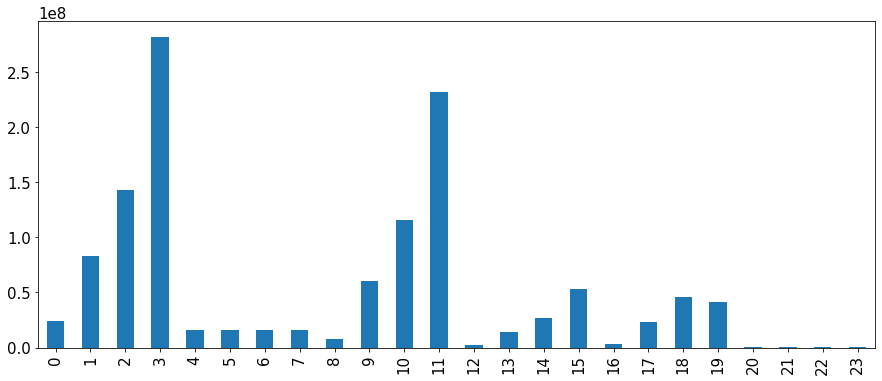

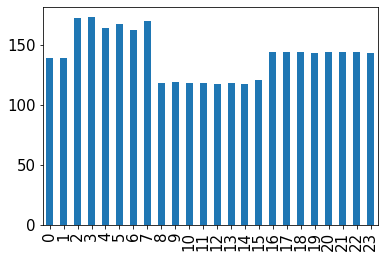

In [355]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()

analyze_table['rtt'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/2754093595.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


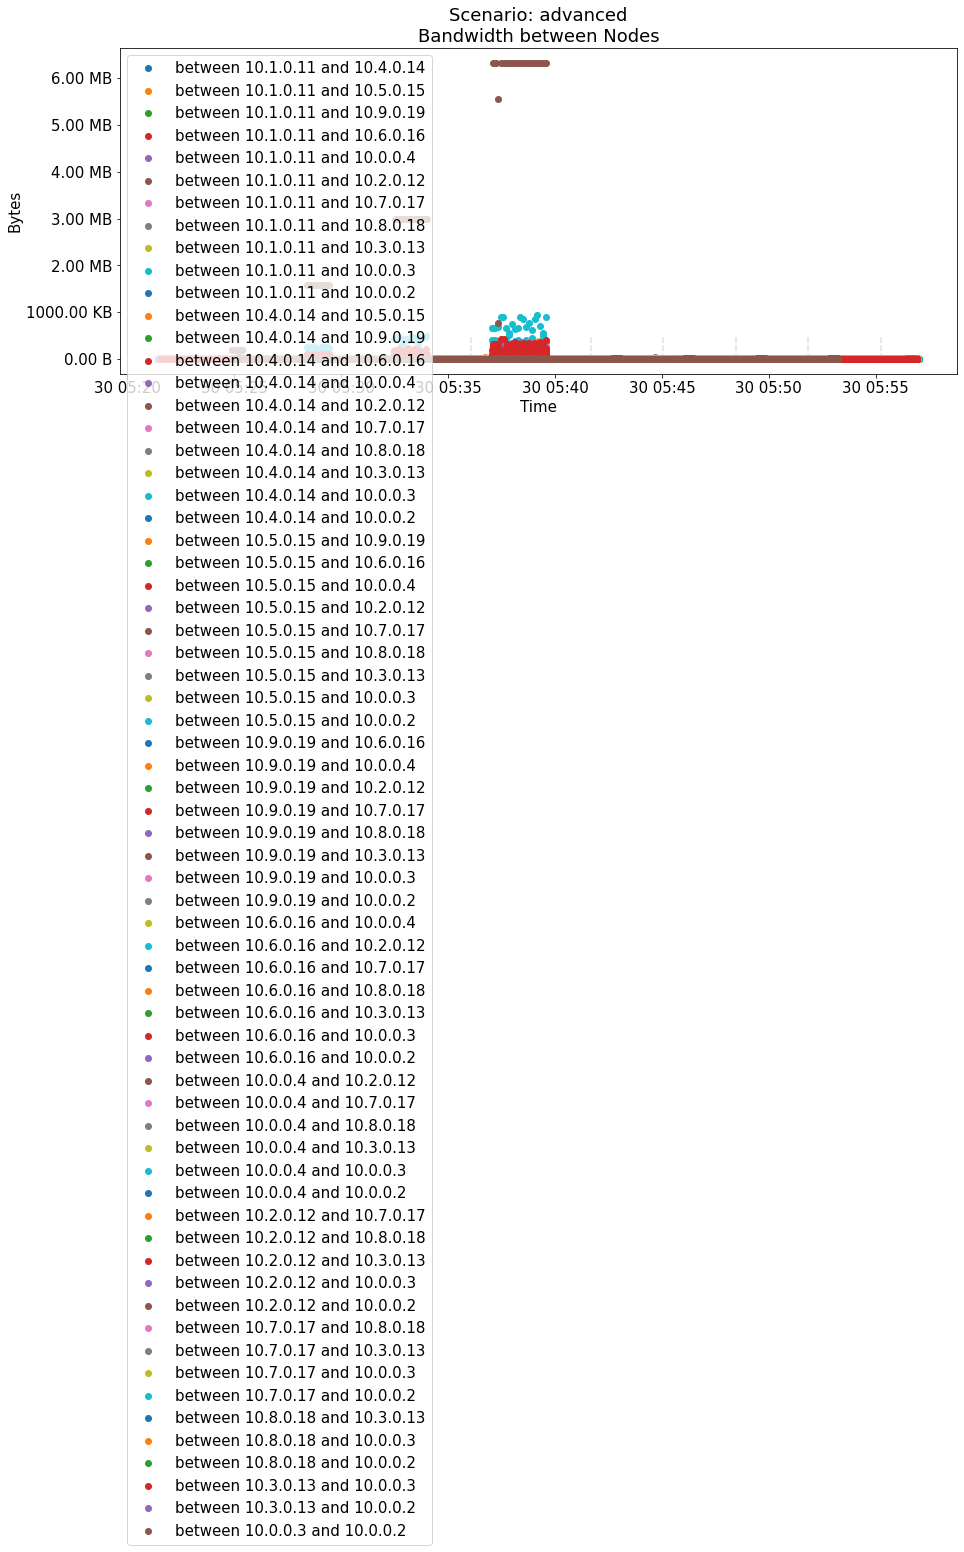

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/2754093595.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


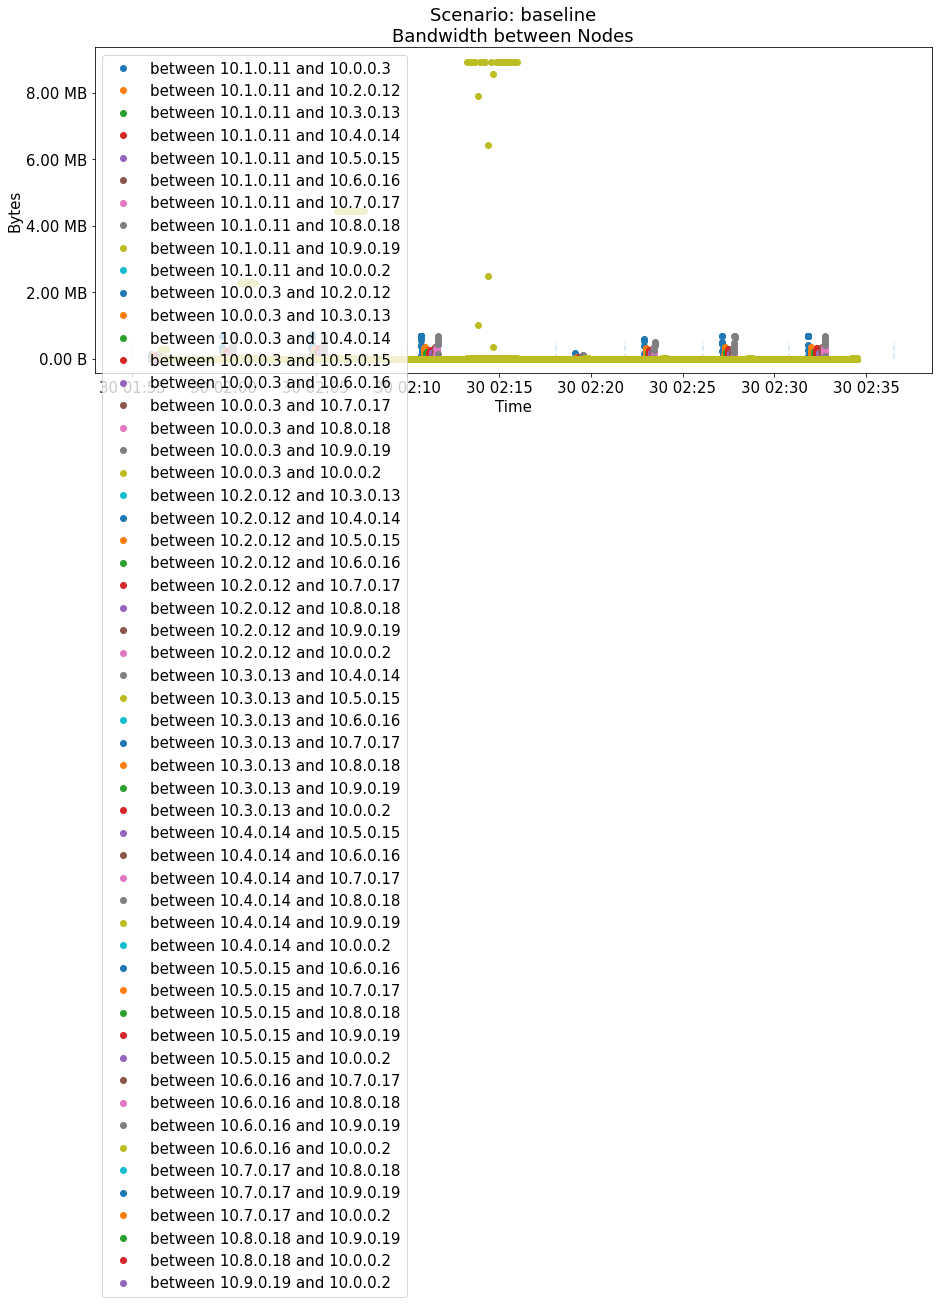

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/2754093595.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


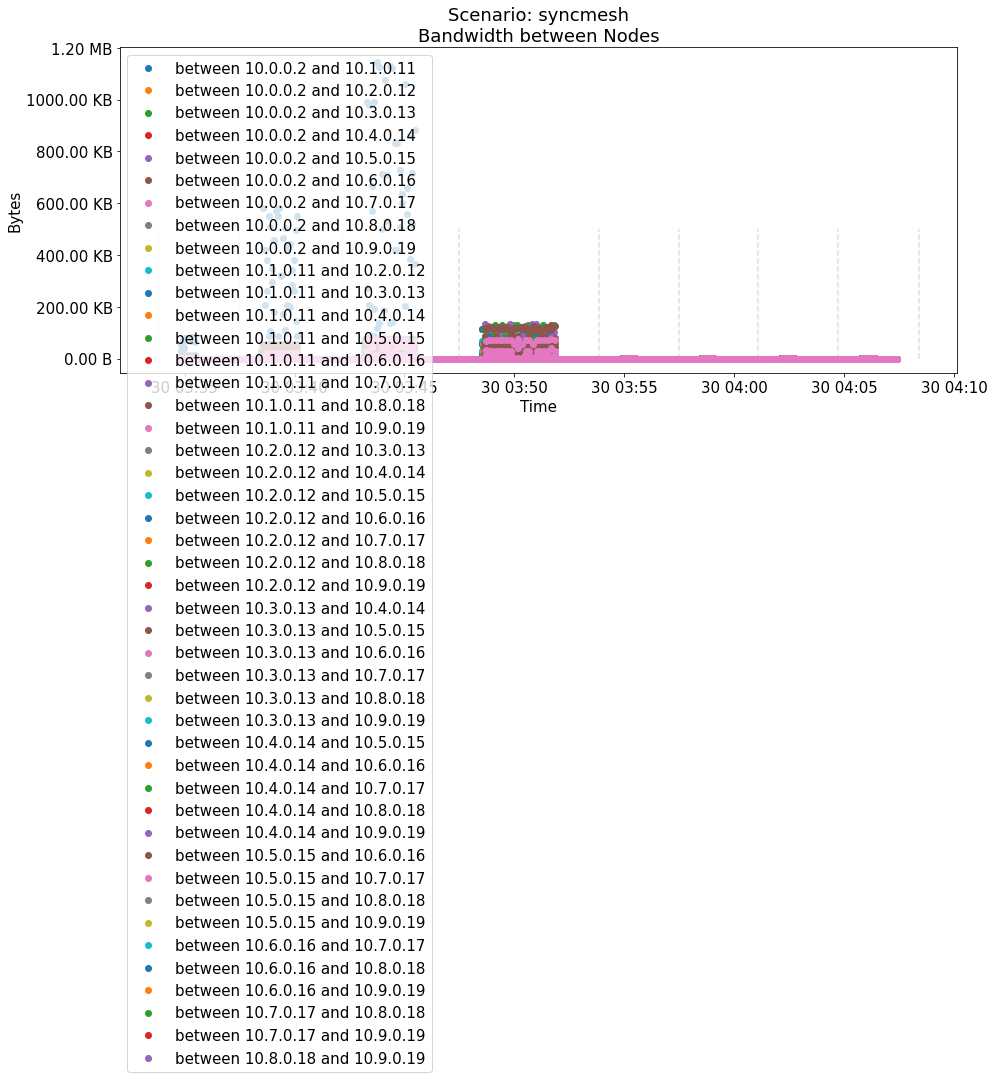

In [356]:
def show_traffic_distribution(dataset, timings, name):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    # ax.set_ylim(0,500)
    for key in dataset: 
        test = dataset[key].resample('100ms').agg({"ip.len":'sum'})
        ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
    # for key in fromClientDataset: 
    #     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
    #     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
    # set title and legend

    for timing in list(pd.to_datetime(timings)): 
        ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
    ax.set_title('Scenario: '+name+'\nBandwidth between Nodes')
    ax.set_ylabel("Bytes")
    ax.set_xlabel("Time")
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
    ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                        ax.get_yticks(minor=False)])
    ax.legend(loc='upper left')

    fig.savefig(f"out/bandwidth_between_nodes_{name}.png")
    plt.show()

for key in node_datasets:
    show_traffic_distribution(node_datasets[key], datasets[key][1], key)

# Monitoring

In [376]:
def loadMonitoringDataSet(folder):
    csvfile = os.path.join(Path.cwd(), folder, "monitoring.csv")
    print(csvfile)
    df = pd.read_csv(csvfile)
    df.set_index('timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)

    return df.sort_index()

monitoring_datasets = {}
for source in dataset_sources:
    monitoring_datasets[source] = loadMonitoringDataSet(dataset_sources[source])
    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
monitoring_datasets["syncmesh"]

c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9\monitoring.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-baseline-with-latency-9/20210930-03-experiment-baseline-with-latency-9\monitoring.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-syncmesh-with-latency-9/20210930-04-experiment-syncmesh-with-latency-9\monitoring.csv


cpu_util_experiment-syncmesh-with-latency-9-node-instance-2  \
timestamp                                                                          
2021-09-30 03:24:00                                           0.238161             
2021-09-30 03:25:00                                           0.021517             
2021-09-30 03:26:00                                           0.018864             
2021-09-30 03:27:00                                           0.019321             
2021-09-30 03:28:00                                           0.018795             
...                                                                ...             
2021-09-30 04:53:00                                           0.019203             
2021-09-30 04:54:00                                           0.018776             
2021-09-30 04:55:00                                           0.028337             
2021-09-30 04:56:00                                           0.042535             
2021-09-30 04:57:00                                           0.024400             

                     io_read_experiment-syncmesh-with-latency-9-node-instance-2  \
timestamp                                                                         
2021-09-30 03:24:00                                                0.0            
2021-09-30 03:25:00                                                0.0            
2021-09-30 03:26:00                                                0.0            
2021-09-30 03:27:00                                                0.0            
2021-09-30 03:28:00                                                0.0            
...                                                                ...            
2021-09-30 04:53:00                                                0.0            
2021-09-30 04:54:00                                                0.0            
2021-09-30 04:55:00                                                0.0            
2021-09-30 04:56:00                                                0.0            
2021-09-30 04:57:00                                                0.0            

                     io_write_experiment-syncmesh-with-latency-9-node-instance-2  \
timestamp                                                                          
2021-09-30 03:24:00                                                0.0             
2021-09-30 03:25:00                                                0.0             
2021-09-30 03:26:00                                                0.0             
2021-09-30 03:27:00                                                0.0             
2021-09-30 03:28:00                                                0.0             
...                                                                ...             
2021-09-30 04:53:00                                                0.0             
2021-09-30 04:54:00                                                0.0             
2021-09-30 04:55:00                                                0.0             
2021-09-30 04:56:00                                                0.0             
2021-09-30 04:57:00                                                0.0             

                     iops_read_experiment-syncmesh-with-latency-9-node-instance-2  \
timestamp                                                                           
2021-09-30 03:24:00                                                0.0              
2021-09-30 03:25:00                                                0.0              
2021-09-30 03:26:00                                                0.0              
2021-09-30 03:27:00                                                0.0              
2021-09-30 03:28:00                                                0.0              
...                                                                ...              
2021-09-30 04:53:00                                                0.0     

In [377]:
# Experiments
def splitMonitoringExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = df.loc[str(timings[index]):str(timings[index + 1])]
    return return_data

monitoring_experiment_datasets = {}
for key in monitoring_datasets:
    print(key)
    print(datasets[key][1])
    monitoring_experiment_datasets[key] = splitMonitoringExperiments(monitoring_datasets[key], datasets[key][1])

setname = "syncmesh"
for key in monitoring_experiment_datasets[setname]:
    print(key, ":", len(monitoring_experiment_datasets[setname][key]))


advanced
['2021-09-30T05:23:50.610327000' '2021-09-30T05:27:22.394546000'
 '2021-09-30T05:31:27.654408000' '2021-09-30T05:36:02.990863000'
 '2021-09-30T05:41:40.878929000' '2021-09-30T05:45:03.994455000'
 '2021-09-30T05:48:27.146498000' '2021-09-30T05:51:50.666404000'
 '2021-09-30T05:55:14.226453000']
baseline
['2021-09-30T01:55:01.960870000' '2021-09-30T01:58:52.292705000'
 '2021-09-30T02:03:45.272522000' '2021-09-30T02:09:42.044462000'
 '2021-09-30T02:18:05.676446000' '2021-09-30T02:21:50.928791000'
 '2021-09-30T02:26:06.816309000' '2021-09-30T02:30:48.048485000'
 '2021-09-30T02:36:29.928731000']
syncmesh
['2021-09-30T03:33:46.648583000' '2021-09-30T03:37:27.320245000'
 '2021-09-30T03:42:08.400047000' '2021-09-30T03:47:29.192840000'
 '2021-09-30T03:53:52.020462000' '2021-09-30T03:57:28.836747000'
 '2021-09-30T04:01:06.131919000' '2021-09-30T04:04:44.348004000'
 '2021-09-30T04:08:24.176003000']
collect1 : 4
collect7 : 5
collect14 : 5
collect30 : 6
aggregate1 : 4
aggregate7 : 4
aggrega

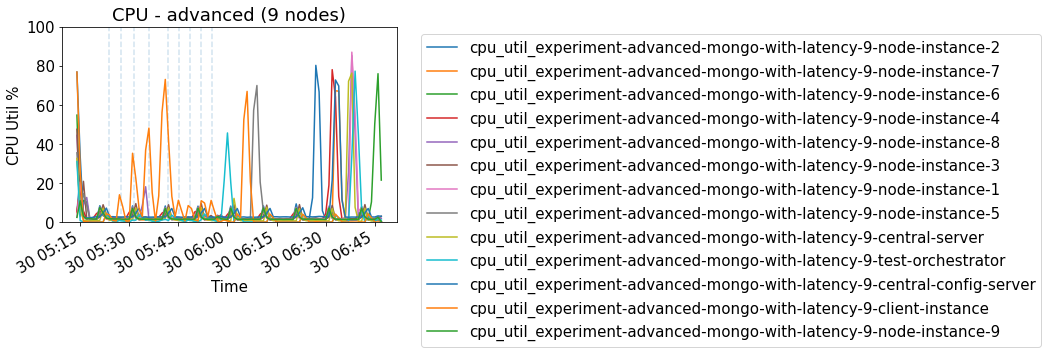

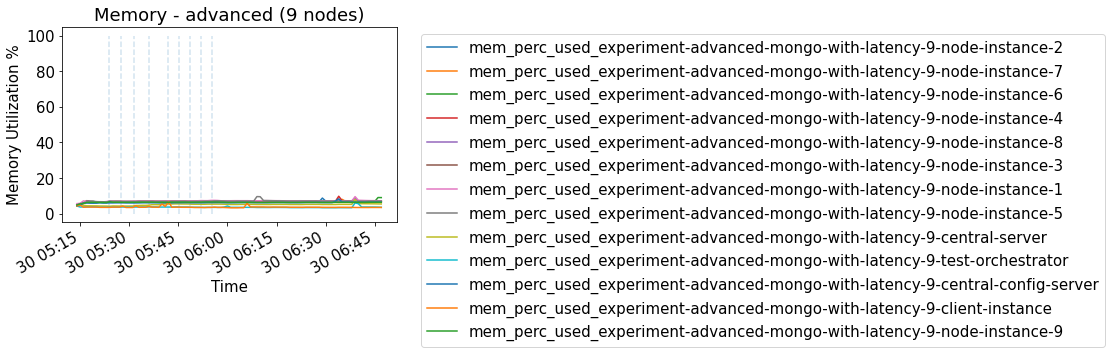

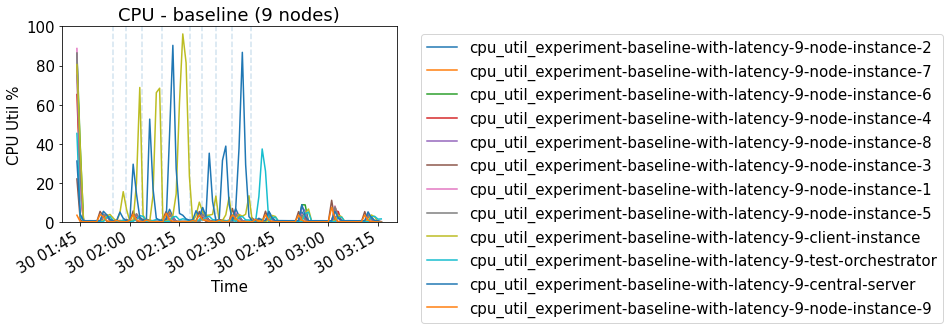

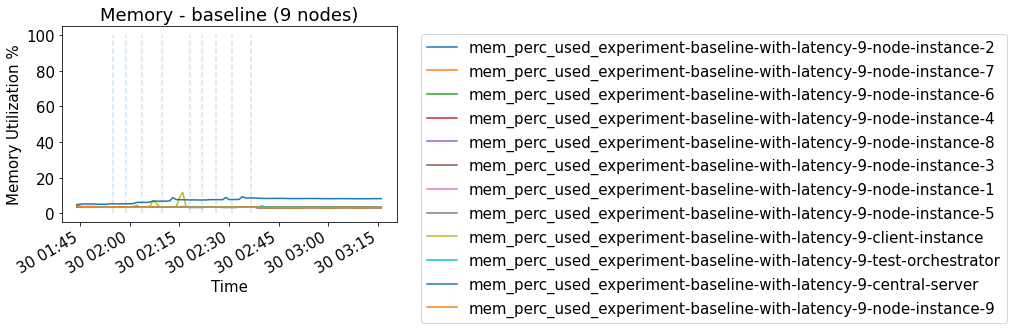

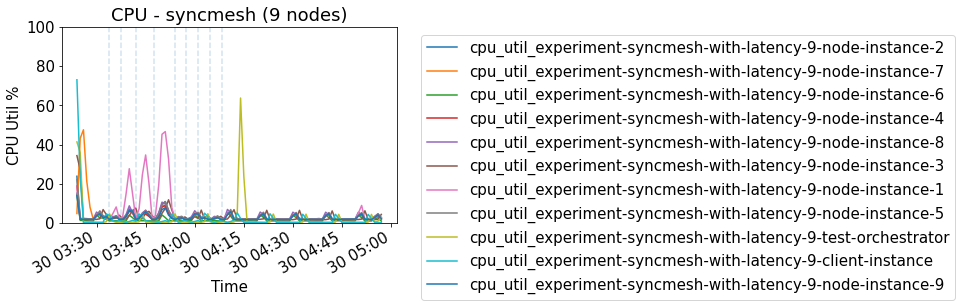

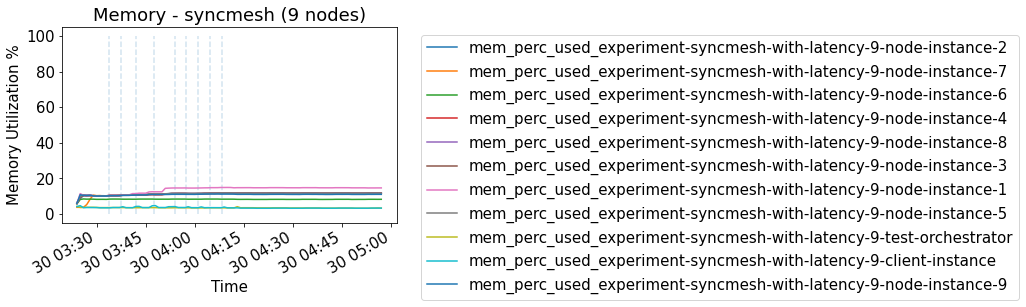

In [384]:
def drawMonitoringGraphCPU(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    ax.set_ylim(0,100)

    for col in columns: 
        if col.startswith("cpu_"):
            ax.plot(df.index, df[col]*100, label=col)

    for timing in list(pd.to_datetime(datasets[name][1])): 
        ax.vlines(timing, 0, 100, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('CPU - ' + name + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("CPU Utilization %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/cpu_util_" + name + ".png")
    plt.show()

def drawMonitoringGraphRAM(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    # ax.set_ylim(0,100)
    max_y = 100
    for col in columns: 
        if col.startswith("mem_perc_used") and "used" in col:
            # print(len(df[col]))
            ax.plot(df.index, df[col], label=col)
            max_y = max(max_y, df[col].max())

    for timing in list(pd.to_datetime(datasets[name][1])): 
        ax.vlines(timing, 0, max_y, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('Memory - ' + name + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("Memory Utilization %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/ram_util_" + name + ".png")
    plt.show()


# drawMonitoringGraphRAM(monitoring_datasets["advanced"], source)

# monitoring_datasets["advanced"]["mem_perc_cached_experiment-advanced-mongo-with-latency-3-central-config-server"].min()
# monitoring_datasets["advanced"]["mem_perc_cached_experiment-advanced-mongo-with-latency-3-node-instance-1"].max()
for source in monitoring_datasets:
    drawMonitoringGraphCPU(monitoring_datasets[source], source)
    drawMonitoringGraphRAM(monitoring_datasets[source], source)


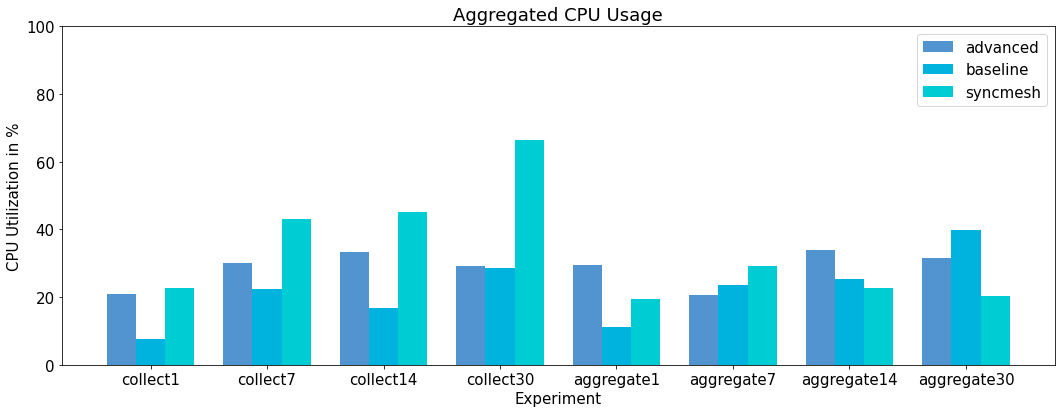

In [379]:
colors = ["#5294CF", "#00B2DE", "#00CCD3"]
def drawMonitoringCPUComparison(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(15, 6))
    labels = np.array([])
    for index, source in enumerate(experiment_datasets):
        X = np.arange(len(experiment_datasets[source].keys()))
        X_labels = experiment_datasets[source].keys()
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)
        # print(sum_cpu_util)
        ax.bar(X - 0.25 + (0.25 * index), sum_cpu_util * 100, color = colors[index], width = 0.25)

    # set title and legend
    ax.set_title('Aggregated CPU Usage' + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("CPU Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Experiment")
    ax.legend(labels=labels)
    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig("out/cpu_comparison.png")
    plt.show()

drawMonitoringCPUComparison(monitoring_experiment_datasets)

[0.20825789 0.3017841  0.33279631 0.29281312 0.29381808 0.20501984
 0.33910108 0.31556259]
[0.07655837 0.22530867 0.16798298 0.28612171 0.110796   0.23453675
 0.25260477 0.39877768]
[0.22626041 0.43057961 0.45187919 0.66345148 0.19579666 0.29241907
 0.22784433 0.2033501 ]


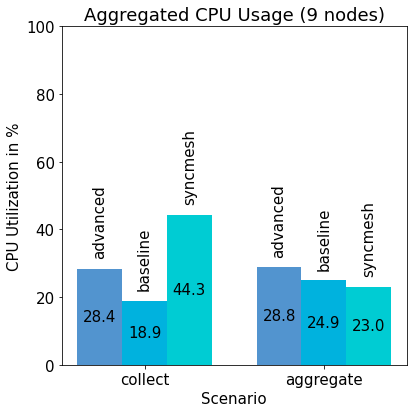

In [390]:
plt.rcParams.update({'font.size': 15})
# Only use two buckets collect and aggregate
def drawMonitoringCPUComparisonAggregate(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    labels = np.array([])
    X_labels = np.array(["collect", "aggregate"])
    X = np.arange(2)

    for index, source in enumerate(experiment_datasets):
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)

        print(sum_cpu_util)
        y = np.array([sum_cpu_util[0:4].mean(), sum_cpu_util[4:8].mean()])
        bar = ax.bar(X - 0.25 + (0.25 * index), y*100, color = colors[index], width = 0.25)
        ax.bar_label(bar, label_type='center',fmt='%.1f')
        # for y_i in range(len(y)):
        for x_i in range(len(X)):
            plt.text(x_i - 0.25 + (0.25 * index), y[x_i] * 100 +4, labels[index], ha = 'center',  rotation=90)
    # set title and legend
    ax.set_title('Aggregated CPU Usage' + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("CPU Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Scenario")
    # ax.legend(labels=labels)

    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig(f'out/cpu_comparison_aggregated_{datasets["baseline"][2]}.png')
    
    plt.show()

drawMonitoringCPUComparisonAggregate(monitoring_experiment_datasets)

[1.09238559e+10 1.08648735e+10 1.37790792e+10 1.38470646e+10
 1.11875564e+10 8.39352320e+09 8.36806246e+09 1.12933970e+10]
[0.06473403 0.0660962 ]
[4.36688896e+09 7.24346470e+09 8.82420941e+09 1.33219410e+10
 4.38677914e+09 7.40798464e+09 5.94287002e+09 9.04841626e+09]
[0.03806883 0.038599  ]
[1.41064929e+10 1.80258079e+10 1.86129777e+10 2.31371448e+10
 1.59055053e+10 1.58493000e+10 1.19634452e+10 1.60988488e+10]
[0.10646547 0.11492955]


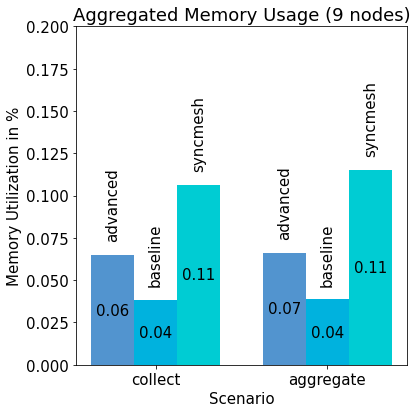

In [391]:
plt.rcParams.update({'font.size': 15})
# Only use two buckets collect and aggregate
def drawMonitoringRAMComparisonAggregate(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    labels = np.array([])
    X_labels = np.array(["collect", "aggregate"])
    X = np.arange(2)

    for index, source in enumerate(experiment_datasets):
        labels = np.append(labels, source)
        sum_mem_used = np.array([])
        sum_mem_free = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            mem_used = np.array([])
            mem_perc_used = np.array([])
            mem_free = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("mem_used") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    mem_used = np.append(mem_used, [df[col]])
                if col.startswith("mem_perc_used") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    mem_perc_used = np.append(mem_perc_used, [df[col]])
                if (col.startswith("mem_free") or col.startswith("mem_slab") or col.startswith("mem_cached") or col.startswith("mem_buffered")) and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    mem_free = np.append(mem_free, [df[col]])
            # See here for Formula for comparise
            sum_mem_used = np.append(sum_mem_used, np.sum(mem_used))
            sum_mem_free = np.append(sum_mem_free, np.sum(mem_free))

        print(sum_mem_used)
        y = np.array([sum_mem_used[0:4].sum() / (sum_mem_used[0:4].sum() + sum_mem_free[0:4].sum()), sum_mem_used[4:8].sum() / (sum_mem_used[4:8].sum() + sum_mem_free[4:8].sum())])
        print(y)
        bar = ax.bar(X - 0.25 + (0.25 * index), y, color = colors[index], width = 0.25)
        ax.bar_label(bar, label_type='center',fmt='%.2f')
        # for y_i in range(len(y)):
        for x_i in range(len(X)):
            plt.text(x_i - 0.25 + (0.25 * index), y[x_i]+ 0.01, labels[index], ha = 'center',  rotation=90)
    # set title and legend
    ax.set_title('Aggregated Memory Usage' + f' ({datasets["baseline"][2]} nodes)')
    ax.set_ylabel("Memory Utilization in %")
    ax.set_ybound(0,0.2)
    ax.set_xlabel("Scenario")
    # ax.legend(labels=labels)

    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig(f'out/ram_comparison_aggregated_{datasets["baseline"][2]}.png')
    
    plt.show()

drawMonitoringRAMComparisonAggregate(monitoring_experiment_datasets)